# Data Analysis on the Relationship Between Natural Disasters and Housing Prices

## Video
**TODO: insert link to video**

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ X ] YES - make available
* [  ] NO - keep private

# Overview

We wanted to measure the relationship between the different aspects of National Risk Index score (ie. Expected Annual Loss and social vulnerabiltiy) versus housing prices. We found data regarding housing prices, national risk index, and disaster frequency to help us with our analysis. Once we cleaned our data, we performed exploratory data analysis and performed linear regression across our predictors to find a relationship with housing prices. We also took into account other confounds such as climate and personal income per capita. 

Once we finished our analysis, we found no correlation between any aspect of NRI score and housing prices. **Michael: Add your results here**

**TODO: insert table of contents**

# Names

- Tyler Le
- Aditya Tomar
- William Lynch
- Michael Mao
- Natalie Quach

<a id='research_question'></a>
# Research Question

Is there a positive correlation between housing price and the various components of the national risk index score (expected annual loss and social vulnerability) defined by the Federal Emergency Management Agency (FEMA) at the county level?

<a id='background'></a>

## Background & Prior Work

Every year, natural disasters strike cities across the United States, injuring and killing civilians and causing millions of dollars worth of private property and infrastructure damage. For example, in 2021 the United States experienced 20 natural disaster events with losses of more than one billion dollars<sup><b><font color="blue">[1]</font></b></sup>. The current news is always reporting on wildfires on the West Coast, hurricanes in the South and East, and tornadoes in the Midwest. It's seems logical to avoid areas with frequent major natural disasters, yet Texas, California, and Florida are the most populated states in the country. Are the negative effects of natural disasters enough to discourage prospective residents and drop cost of living (due to lower housing prices), or would people rather endure natural disasters and their expenses? 

There have been many studies done in the past to answer the same question, yet there is still much debate over the answer and even controversy regarding various studies’ data analysis. An article written by the U.S. Bureau of Labor Statistics concluded that areas hit with severe disasters have increased outmigration, lower home prices, and higher poverty rates because there is lower demand to live in the area <sup><b><font color="blue">[2]</font></b></sup>. The Federal Emergency Management Agency (FEMA) created a risk map that shows that the Northern states are generally safer<sup><b><font color="blue">[3]</font></b></sup> but use potentially subjective and biased metrics such as “Social Vulnerability” and “Community Resilience” as part of their risk calculation. With our data, we want to conduct a standardized analysis of the severity of natural disasters compared to a state's cost of living and determine how they are correlated.

1. https://worldpopulationreview.com/state-rankings/cost-of-living-index-by-state 
2. https://www.bls.gov/opub/mlr/2017/beyond-bls/the-effect-of-natural-disasters-on-local-economies.htm
3. https://hazards.fema.gov/nri/map# 

# Hypothesis


We hypothesize that the National Risk Index score will be positively correlated with housing prices because of the expenses of rebuilding, relief aid, and catastrophe insurance. However, we think there isn't a strong correlation because other factors such as climate and personal income per capita also drive up the housing prices. For example, California is at risk for natural disasters and high housing prices.

# Dataset(s)

**1. Frequency of Disasters By State**
- Dataset Name: Billion-Dollar Disasters By Year (CPI-Adjusted) (natural_disaster_frequencies.csv)
- Link to the dataset: https://www.ncdc.noaa.gov/billions/state-freq-data.csv
- Number of observations: 2228 
- Number of features: 9. These features are mostly numerical.

This dataset contains the count of natural disasters that cost more than 1 billion dollars for each state from 1980 - 2021. Each observation contains one state and the count of each natural disaster type for a given year.

**2. Types of Disaster By State/County**
- Dataset Name: Disaster Declarations Summaries (DisasterDeclarationsSummaries.csv)
- Link to the dataset: https://www.fema.gov/api/open/v1/DisasterDeclarationsSummaries.csv
- Number of observations: 62771
- Number of features: 23. Contains a combination of numerical and string data types.

This dataset contains all federally declared natural disasters from 1953-2022 (by year, state, county, and type) along with declared recovery programs. Each observation contains the type of natural disaster, when it occurred, and the state/county it occured in.


**3. National Risk Index (NRI)**
- Dataset Name: National Risk Index per County (NRI_Table_Counties.csv)
- Link to the dataset: https://hazards.fema.gov/nri/data-resources#csvDownload
- Number of observations: 3142
- Number of features: 365. Contains a combination of numerical and string data types.

Dataset from FEMA that identifies counties and states most at risk to 18 natural hazards. Includes data about expected annual losses from natural hazards, social vulnerability and community resilience. 


**4. Climate**
- Dataset Name: Average Climate by County (Average_Climate_By_County.csv)
- Link to the dataset: https://www.ncdc.noaa.gov/cag/county/mapping
- Number of observations: 3137
- Number of features: 3. Contains a combination of numerical and string types.

This dataset contains the mean climate (measured in Fahrenheit) over a 5-year span from 2017 to 2022 for all counties in the USA except those in Hawaii. This dataset is for comparing the correlation between natural disasters vs cost of living with climate vs cost of living because climate is a potential confounding variable that affects cost of living.

**5. Housing Price**
- Dataset Name: Housing Price Estimates
- Link to the dataset: https://www.nar.realtor/research-and-statistics/housing-statistics/county-median-home-prices-and-monthly-mortgage-payment
- Number of observations: 3120
- Number of features: 118

This dataset contains quarterly housing prices for each county since 2017. This dataset is for comparing the effects of natural disasters and confounding variables to the cost of living measured using housing prices.  

**6. Personal Income Per Capita**
- Dataset Name: Income per Capita
- Link to the dataset: https://apps.bea.gov/iTable/iTable.cfm?reqid=70&step=1&acrdn=6
- Number of observations: 3159
- Number of features: 6

This dataset contains data on personal income per capita for each county for the years 2017-2020. This dataset is for comparing the correlation between average income and housing prices to the correlation between the impacts of natural disasters and housing prices.

# Setup

In [770]:
# add necessary packages here

# ! pip install kaleido
# ! pip install addfips

In [771]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import os
from pathlib import Path

# converting city to county
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm # progress bar for .apply()

# for choropleth
import plotly.express as px

# used for choropleth
from urllib.request import urlopen
import json

# filter extra noise from warnings
import warnings
warnings.filterwarnings('ignore')

# Statmodels & patsy
import patsy
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import boxcox


# Make plots just slightly bigger for displaying well in notebook
plt.rcParams['figure.figsize'] = (10, 5)

# Displaying figures as image
from IPython.display import Image

%config InlineBackend.figure_format ='retina'

# Data Cleaning

**Frequency of Disaster By State:** This dataset was fairly clean in that there were no missing values and each observation contains whether or not a state had a natural disaster event in a certain year. We decided to remove spaces from the column names and to replace them with underscores. Since each column describing a natural disaster contains the count of how many natural disasters of that type, there was little data cleaning needed for this dataset.

**Types of Disasters By State/County:** This dataset was fairly clean. We first focused on extracting the relevant columns, which were "state", "declarationType", "incidentType", "declarationTitle", and "declarationArea". These were the relevant variables since we want each state, the type of natural disaster, and whether it occured on a county level or not. We filtered the dataset to only contain natural disasters that occurred at the county level and standardized the column. We decided to keep the year it happened rather than the exact month and day since in our EDA in the future we would like to explore the natural disaster frequencies by decade. To make future analyses more convienient, we renamed some of the column names. Also, we checked for missing values and found that there were none. 

**National Risk Index:** This dataset was fairly clean. We focused on extracting the relevant columns, such as county, population size, National Risk Index score, and expected annual loss. These variables are important because we would like to compare counties per capita. We also decided to lowercase all the columns and replace spaces with underscores for consistency across all dataframes.

**Average Climate by County**
This dataset was very clean. All that we needed to change was remove ID numbers after the state abbreviations and change the column names from "Location ID" to "State", "Location" to "County", and "Value" to "Temperature (F)". 

**Median House Prices by County**
This dataset needed a lot of cleaning since there were a lot of unnecessary columns, many typos, and the data was not standardized. We needed to extract relevant columns, remove unnecessary characters from numbers (such as '$'), combine quarterly data into annual data, and turn FIPS codes into 5 character strings.

**Climate vs Housing Prices**
This dataset is a combination of our Climate dataset and our Housing Prices dataset. To create this we needed to extract climate values from our climate dataset and match them up to the correct county in our Housing Prices dataset using FIPS codes. Then we created two new columns with log transformed values for the years 2017 and 2021 for our EDA.

**Personal Income per Capita**
This dataset had some missing values which needed to be removed. Also, because we wanted to perform linear regressions using this data we needed to log transform all the values in order to create a roughly normal distribution.

**Income vs Housing Prices**
This dataset is a combination of our Income dataset and our Housing Prices dataset. To create this we needed to extract income values from our income dataset and match them up to the correct county in our Housing Prices dataset using FIPS codes. This dataset also needed log transformed values for both income and housing prices.

## Frequency of Disaster By State

In [772]:
freq_df = pd.read_csv('datasets/natural_disaster_frequencies.csv')

# replace space with underscores in column names
freq_df.columns = freq_df.columns.str.replace(' ', '_')

# check for NaNs
assert(freq_df.isna().sum().sum() == 0)

freq_df.head()

year state  drought  flooding  freeze  severe_storm  tropical_cyclone  \
0  1980    AK        0         0       0             0                 0   
1  1980    AL        1         0       0             0                 0   
2  1980    AR        1         1       0             0                 0   
3  1980    AZ        0         0       0             0                 0   
4  1980    CA        0         0       0             0                 0   

   wildfire  winter_storm  
0         0             0  
1         0             0  
2         0             0  
3         0             0  
4         0             0

## Types of Disaster By State & County

In [773]:
def standardize_county(str_in):
    try:
        if '(County)' in str_in:
            output = str_in.replace('(County)','')
        else:
            output = None
    except: 
        output = None

    return output


def standardize_year(str_in):
    try:
        output = str_in.split('T')[0]
        output = pd.to_datetime(str_in).year
    except:
        output = None
        
    return output

In [774]:
disaster_type_df = pd.read_csv('datasets/DisasterDeclarationsSummaries.csv')

# select a subset of the columns
wanted_columns = ['state', 'declarationDate','incidentType','declarationTitle','designatedArea']

# rename the columns
disaster_type_df = disaster_type_df[wanted_columns].rename(columns={"declarationDate":"year", "designatedArea": "county", "incidentType":"disaster_type", "declarationTitle":"disaster_declaration"})

# Set "Statewide" to None and strip "(County)" from all counties
disaster_type_df['county'] = disaster_type_df['county'].apply(standardize_county)

# filter dataset to only include non-null 
disaster_type_df = disaster_type_df[~disaster_type_df['county'].isnull()]

# strip year column to only include year
disaster_type_df['year'] = disaster_type_df['year'].apply(standardize_year)

# sort by year
disaster_type_df = disaster_type_df.sort_values('year').reset_index(drop = True)

# check for no NaNs
assert(disaster_type_df.isna().sum().sum() == 0)

disaster_type_df.head()

state  year disaster_type    disaster_declaration      county
0    IN  1959         Flood                   FLOOD       Clay 
1    WA  1964         Flood  HEAVY RAINS & FLOODING  Wahkiakum 
2    WA  1964         Flood  HEAVY RAINS & FLOODING   Skamania 
3    WA  1964         Flood  HEAVY RAINS & FLOODING     Pierce 
4    WA  1964         Flood  HEAVY RAINS & FLOODING    Pacific

## National Risk Index


In [775]:
# Look at the "NRI Data Dictionary in the datasets/NRI_Table_Counties" to see what the cols mean
# EAL = "Expected Annual Lost", quantifies the anticipated economic damage resulting from natural hazards each year. 
# 1-100 scale

df_nri = pd.read_csv('datasets/NRI_Table_Counties/NRI_Table_Counties.csv')

# select a subset of the columns
wanted_cols = ['STATE','STATEABBRV','STATEFIPS','COUNTY','COUNTYFIPS','POPULATION','AREA','RISK_SCORE','RISK_RATNG',
               'EAL_SCORE','EAL_RATNG', 'SOVI_SCORE', 'RESL_SCORE']
df_nri = df_nri[wanted_cols]

# lowercase all columns
df_nri.columns = df_nri.columns.str.lower()

# rename columns
df_nri = df_nri.rename(columns={"stateabbrv":"state_abbrv", "risk_ratng":"risk_rating" ,"eal_ratng":"eal_rating","statefips":"state_fips","countyfips":"county_fips"})

# we need state and county FIPS information (already included in NRI dataset)
df_nri['state_fips'] = df_nri['state_fips'].apply(lambda x: str(x).zfill(2))
df_nri['county_fips'] = df_nri['county_fips'].apply(lambda x: str(x).zfill(3))
df_nri['fips'] = df_nri['state_fips'] + df_nri['county_fips']

In [776]:
# Need to convert risk/eal rating to values.
df_nri['risk_rating'].value_counts()
encoding_dict = {"Very Low": 1, "Relatively Low":2, "Relatively Moderate": 3, "Relatively High": 4, "Very High": 5}

def encode_ratings(str_in):
    return (encoding_dict[str_in])

In [777]:
df_nri['risk_encoded'] = df_nri['risk_rating'].apply(encode_ratings)
df_nri['eal_encoded'] = df_nri['eal_rating'].apply(encode_ratings)

# make sure there are no NaNs
assert(df_nri.isna().sum().sum() == 0)

In [778]:
df_nri.to_csv("datasets/cleaned/nri.csv",index=False)
df_nri.head()

state state_abbrv state_fips   county county_fips  population  \
0  Kentucky          KY         21  Johnson         115       23356   
1  Kentucky          KY         21   Kenton         117      159720   
2  Kentucky          KY         21    Knott         119       16346   
3  Kentucky          KY         21     Knox         121       31883   
4  Kentucky          KY         21    Larue         123       14193   

         area  risk_score     risk_rating  eal_score           eal_rating  \
0  261.958144    9.281419  Relatively Low  11.921944       Relatively Low   
1  160.213975   10.449057  Relatively Low  16.837131  Relatively Moderate   
2  351.517978   10.068395  Relatively Low  10.945913       Relatively Low   
3  386.298435   11.858245  Relatively Low  11.983719       Relatively Low   
4  261.539564    4.610900        Very Low   7.028611             Very Low   

   sovi_score  resl_score   fips  risk_encoded  eal_encoded  
0   34.450138   51.128602  21115             2            2  
1   30.508475   56.803002  21117             2            3  
2   38.628301   48.523402  21119             2            2  
3   43.634214   50.953798  21121             2            2  
4   31.533307   55.515800  21123             1            1

## Climate by County

In [779]:
# Dataset for the mean climate for each county in the USA except those in Hawaii. The climate is measured over a 5-year span from 2017-2022. 
climate_df = pd.read_csv('datasets/Average_Climate_By_County.csv')
climate_df['fips'] = climate_df['Location ID']
climate_df['Location ID'] = climate_df['Location ID'].apply([lambda x: x[0:2]])
climate_df = climate_df.rename(columns={'Location ID': 'State', 'Location': 'County', 'Value': 'Temperature (F)'})


#Converts "Location ID" to fips codes
def calculate_fips(string):    
    string = string.replace('AL-', '01')
    string = string.replace('AK-', '02')
    string = string.replace('AZ-', '04')
    string = string.replace('AR-', '05')
    string = string.replace('CA-', '06')
    string = string.replace('CO-', '08')
    string = string.replace('CT-', '09')
    string = string.replace('DE-', '10')
    string = string.replace('FL-', '12')
    string = string.replace('GA-', '13')
    string = string.replace('HI-', '15')
    string = string.replace('ID-', '16')
    string = string.replace('IL-', '17')
    string = string.replace('IN-', '18')
    string = string.replace('IA-', '19')
    string = string.replace('KS-', '20')
    string = string.replace('KY-', '21')
    string = string.replace('LA-', '22')
    string = string.replace('ME-', '23')
    string = string.replace('MD-', '24')
    string = string.replace('MA-', '25')
    string = string.replace('MI-', '26')
    string = string.replace('MN-', '27')
    string = string.replace('MS-', '28')
    string = string.replace('MO-', '29')
    string = string.replace('MT-', '30')
    string = string.replace('NE-', '31')
    string = string.replace('NV-', '32')
    string = string.replace('NH-', '33')
    string = string.replace('NJ-', '34')
    string = string.replace('NM-', '35')
    string = string.replace('NY-', '36')
    string = string.replace('NC-', '37')
    string = string.replace('ND-', '38')
    string = string.replace('OH-', '39')
    string = string.replace('OK-', '40')
    string = string.replace('OR-', '41')
    string = string.replace('PA-', '42')
    string = string.replace('RI-', '44')
    string = string.replace('SC-', '45')
    string = string.replace('SD-', '46')
    string = string.replace('TN-', '47')
    string = string.replace('TX-', '48')
    string = string.replace('UT-', '49')
    string = string.replace('VT-', '50')   
    string = string.replace('VA-', '51')
    string = string.replace('WA-', '53')
    string = string.replace('WV-', '54')
    string = string.replace('WI-', '55')
    string = string.replace('WY-', '56')
    string = string.strip()
    if string.isnumeric():
        output = string
    else:
        output = np.nan
    
    return output

climate_df['fips'] = climate_df['fips'].apply(calculate_fips)
climate_df.head()

State          County  Temperature (F)   fips
0    AL  Autauga County             65.7  01001
1    AL  Baldwin County             68.4  01003
2    AL  Barbour County             66.0  01005
3    AL     Bibb County             63.9  01007
4    AL   Blount County             62.7  01009

## Median House Prices by County

In [780]:
#Read original dataset
temp_df = pd.read_csv("datasets/housing_price_estimates.csv")
temp_housing_df = temp_df[['Geography','Full County Number','Q1 2017 Price','Q2 2017 Price','Q1 2018 Price','Q2 2018 Price','Q3 2018 Price','Q42019 Price','Q3 2020 Price','Q4 2020 Price','Q1 2021','Q2 2021']]
temp_housing_df.head()

Geography  Full County Number Q1 2017 Price  Q2 2017 Price  \
0  Autauga County,  Alabama                1001     $146,540    143866.91580   
1  Baldwin County,  Alabama                1003     $185,678    184948.65580   
2  Barbour County,  Alabama                1005      $97,725     97341.39779   
3     Bibb County,  Alabama                1007     $114,543    117562.16530   
4   Blount County,  Alabama                1009     $133,614    137136.48240   

   Q1 2018 Price  Q2 2018 Price Q3 2018 Price Q42019 Price Q3 2020 Price  \
0   144090.31680   146201.56650     $142,792     $153,716      $160,201    
1   204174.86670   202249.70900     $210,870     $209,494      $231,103    
2    91255.33332    90394.88998      $94,248     $100,423       $93,954    
3   107422.34270   111724.72890     $112,903     $101,799       $97,170    
4   124426.63770   129410.06510     $130,775     $131,548      $133,818    

  Q4 2020 Price    Q1 2021    Q2 2021  
0     $161,743   $163,383   $169,254   
1     $234,357   $238,582   $248,705   
2      $95,277    $96,994   $101,110   
3      $98,445    $99,436   $105,213   
4     $135,574   $136,938   $144,894

In [781]:
#Removes '$' and ',' from numbers
temp_housing_df = temp_housing_df.dropna()
def remove_dollar (x):
    if type(x) == str: 
        x = x.replace('$','')
        x = x.replace(',','')
       
        return int(x)
    else: return int(x)

for col in temp_housing_df:
    if((col != 'Geography') & (col != 'Full County Number')):
        temp_housing_df[col] = temp_housing_df[col].apply(lambda x: remove_dollar(x))
temp_housing_df = temp_housing_df.rename(columns={'Q42019 Price':'Q4 2019 Price', 'Q1 2021':'Q1 2021 Price', 'Q2 2021':'Q2 2021 Price', 'Full County Number':'FIPS'})
temp_housing_df.head()

Geography  FIPS  Q1 2017 Price  Q2 2017 Price  \
0  Autauga County,  Alabama  1001         146540         143866   
1  Baldwin County,  Alabama  1003         185678         184948   
2  Barbour County,  Alabama  1005          97725          97341   
3     Bibb County,  Alabama  1007         114543         117562   
4   Blount County,  Alabama  1009         133614         137136   

   Q1 2018 Price  Q2 2018 Price  Q3 2018 Price  Q4 2019 Price  Q3 2020 Price  \
0         144090         146201         142792         153716         160201   
1         204174         202249         210870         209494         231103   
2          91255          90394          94248         100423          93954   
3         107422         111724         112903         101799          97170   
4         124426         129410         130775         131548         133818   

   Q4 2020 Price  Q1 2021 Price  Q2 2021 Price  
0         161743         163383         169254  
1         234357         238582         248705  
2          95277          96994         101110  
3          98445          99436         105213  
4         135574         136938         144894

In [782]:
#Calculates mean of quarters for each year if necessary
temp_housing_df['County & State'] = temp_housing_df['Geography']
temp_housing_df['FIPS'] = temp_housing_df['FIPS'].apply(lambda x: str(x))
temp_housing_df['FIPS'] = temp_housing_df['FIPS'].apply(lambda x: x.zfill(5))
temp_housing_df['2017'] = (temp_housing_df['Q1 2017 Price'] + temp_housing_df['Q2 2017 Price'])/2
temp_housing_df['2018'] = (temp_housing_df['Q1 2018 Price'] + temp_housing_df['Q2 2018 Price'] + temp_housing_df['Q3 2018 Price'])/3
temp_housing_df['2019'] = (temp_housing_df['Q4 2019 Price'])
temp_housing_df['2020'] = (temp_housing_df['Q3 2020 Price'] + temp_housing_df['Q4 2020 Price'])/2
temp_housing_df['2021'] = (temp_housing_df['Q1 2021 Price'] + temp_housing_df['Q2 2021 Price'])/2

temp_housing_df = temp_housing_df.astype({'2017': 'int32', '2018': 'int32','2019': 'int32','2020': 'int32','2021': 'int32'})
housing_df = temp_housing_df[['County & State','FIPS','2017', '2018', '2019', '2020','2021']]

housing_df.head()
#housing_df.to_csv("datasets/cleaned/NewHousingPrices2017-2021.csv")

County & State   FIPS    2017    2018    2019    2020    2021
0  Autauga County,  Alabama  01001  145203  144361  153716  160972  166318
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730  243643
2  Barbour County,  Alabama  01005   97533   91965  100423   94615   99052
3     Bibb County,  Alabama  01007  116052  110683  101799   97807  102324
4   Blount County,  Alabama  01009  135375  128203  131548  134696  140916

## Climate & Housing Prices

In [783]:
#creates a new data frame using both Climate and Housing Prices data
def extract_climate(fips):
    try:
        temp = climate_df[(climate_df['fips'] == fips)]
        return temp['Temperature (F)']
    except:
        return np.nan

housing_climate_df = housing_df
housing_climate_df['climate'] = np.nan
housing_climate_df.head()

County & State   FIPS    2017    2018    2019    2020    2021  \
0  Autauga County,  Alabama  01001  145203  144361  153716  160972  166318   
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730  243643   
2  Barbour County,  Alabama  01005   97533   91965  100423   94615   99052   
3     Bibb County,  Alabama  01007  116052  110683  101799   97807  102324   
4   Blount County,  Alabama  01009  135375  128203  131548  134696  140916   

   climate  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [784]:
#Extracts climate for all rows in housing dataset
for i in range (0, len(housing_climate_df)):
    try:
        housing_climate_df.at[i,'climate'] = extract_climate(housing_climate_df['FIPS'][i])
    except:
        if(housing_climate_df.iloc[i,7] == np.nan):
            housing_climate_df.iloc[i,7] = housing_climate_df.iloc[i,7] #do nothing

housing_climate_df = housing_climate_df.dropna()
housing_climate_df = housing_climate_df.rename(columns={'climate':'Climate', 'county':'County'})
housing_climate_df.head()

County & State   FIPS    2017    2018    2019    2020    2021  \
0  Autauga County,  Alabama  01001  145203  144361  153716  160972  166318   
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730  243643   
2  Barbour County,  Alabama  01005   97533   91965  100423   94615   99052   
3     Bibb County,  Alabama  01007  116052  110683  101799   97807  102324   
4   Blount County,  Alabama  01009  135375  128203  131548  134696  140916   

   Climate  
0     65.7  
1     68.4  
2     66.0  
3     63.9  
4     62.7

In [785]:
#log transforming prices because they are skewed very far to the right
housing_climate_df['2017 log'] = np.log(housing_climate_df['2017'])
housing_climate_df['2021 log'] = np.log(housing_climate_df['2021'])
housing_climate_df.head()

County & State   FIPS    2017    2018    2019    2020    2021  \
0  Autauga County,  Alabama  01001  145203  144361  153716  160972  166318   
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730  243643   
2  Barbour County,  Alabama  01005   97533   91965  100423   94615   99052   
3     Bibb County,  Alabama  01007  116052  110683  101799   97807  102324   
4   Blount County,  Alabama  01009  135375  128203  131548  134696  140916   

   Climate   2017 log   2021 log  
0     65.7  11.885888  12.021657  
1     68.4  12.129802  12.403459  
2     66.0  11.487946  11.503400  
3     63.9  11.661794  11.535900  
4     62.7  11.815804  11.855919

In [786]:
#Finds deviance from median for climate and reverses it so bigger numbers means a more moderate climate
housing_climate_df['Climate'].describe()
climate_median = 55.5
housing_climate_df['Climate Deviance from Median'] = -1 * abs(55.5 - 
    housing_climate_df['Climate'])
housing_climate_df.head()

County & State   FIPS    2017    2018    2019    2020    2021  \
0  Autauga County,  Alabama  01001  145203  144361  153716  160972  166318   
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730  243643   
2  Barbour County,  Alabama  01005   97533   91965  100423   94615   99052   
3     Bibb County,  Alabama  01007  116052  110683  101799   97807  102324   
4   Blount County,  Alabama  01009  135375  128203  131548  134696  140916   

   Climate   2017 log   2021 log  Climate Deviance from Median  
0     65.7  11.885888  12.021657                         -10.2  
1     68.4  12.129802  12.403459                         -12.9  
2     66.0  11.487946  11.503400                         -10.5  
3     63.9  11.661794  11.535900                          -8.4  
4     62.7  11.815804  11.855919                          -7.2

## Personal Income per Capita 

In [787]:
income_df = pd.read_csv('datasets/income_per_capita.csv')
income_df = income_df.dropna()
income_df['GeoFips'] = income_df['GeoFips'].apply(lambda x: x.zfill(5))
income_df = income_df.rename(columns={'GeoFips': 'FIPS'})
income_df.head()

FIPS      GeoName   2017   2018   2019   2020
0  01001  Autauga, AL  41629  42931  44368  46814
1  01003  Baldwin, AL  45397  46905  48270  50953
2  01005  Barbour, AL  32759  34064  35572  37850
3  01007     Bibb, AL  29060  30250  31540  34300
4  01009   Blount, AL  34420  35905  36969  38808

In [788]:
#Removing rows with missing values
income_df['2017'] = income_df['2017'].replace('(NA)', np.nan)
income_df['2018'] = income_df['2018'].replace('(NA)', np.nan)
income_df['2019'] = income_df['2019'].replace('(NA)', np.nan)
income_df['2020'] = income_df['2020'].replace('(NA)', np.nan)

income_df = income_df.dropna()
income_df['2017'] = income_df['2017'].apply(lambda x: int(x))
income_df['2018'] = income_df['2018'].apply(lambda x: int(x))
income_df['2019'] = income_df['2019'].apply(lambda x: int(x))
income_df['2020'] = income_df['2020'].apply(lambda x: int(x))

In [789]:
income_df['2017 log'] = np.log(income_df['2017'])
income_df['2020 log'] = np.log(income_df['2020'])
income_df.head()

FIPS      GeoName   2017   2018   2019   2020   2017 log   2020 log
0  01001  Autauga, AL  41629  42931  44368  46814  10.636552  10.753938
1  01003  Baldwin, AL  45397  46905  48270  50953  10.723201  10.838659
2  01005  Barbour, AL  32759  34064  35572  37850  10.396933  10.541386
3  01007     Bibb, AL  29060  30250  31540  34300  10.277118  10.442901
4  01009   Blount, AL  34420  35905  36969  38808  10.446393  10.566382

## Income + Housing

In [790]:
income_housing_df = housing_df[['County & State','FIPS','2017','2018','2019','2020']]

In [791]:
income_housing_df.head()

County & State   FIPS    2017    2018    2019    2020
0  Autauga County,  Alabama  01001  145203  144361  153716  160972
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730
2  Barbour County,  Alabama  01005   97533   91965  100423   94615
3     Bibb County,  Alabama  01007  116052  110683  101799   97807
4   Blount County,  Alabama  01009  135375  128203  131548  134696

In [792]:
#functions to extract income data from income dataset
def extract_income_2017(fips):
    try:
        temp = income_df[(income_df['FIPS'] == fips)]
        return temp['2017 log']
    except:
        return np.nan

def extract_income_2020(fips):
    try:
        temp = income_df[(income_df['FIPS'] == fips)]
        return temp['2020 log']
    except:
        return np.nan


income_housing_df['2017 income log'] = np.nan
income_housing_df['2020 income log'] = np.nan

income_housing_df.head()

County & State   FIPS    2017    2018    2019    2020  \
0  Autauga County,  Alabama  01001  145203  144361  153716  160972   
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730   
2  Barbour County,  Alabama  01005   97533   91965  100423   94615   
3     Bibb County,  Alabama  01007  116052  110683  101799   97807   
4   Blount County,  Alabama  01009  135375  128203  131548  134696   

   2017 income log  2020 income log  
0              NaN              NaN  
1              NaN              NaN  
2              NaN              NaN  
3              NaN              NaN  
4              NaN              NaN

In [793]:
#Extracts income for all rows in housing dataset
for i in range (0, len(income_housing_df)):
    try:
        income_housing_df.at[i,'2017 income log'] = extract_income_2017(income_housing_df['FIPS'][i])
    except:
        if(income_housing_df.iloc[i,6] == np.nan):
            income_housing_df.iloc[i,6] = income_housing_df.iloc[i,6] #do nothing


#Extracts income for all rows in housing dataset
for i in range (0, len(income_housing_df)):
    try:
        income_housing_df.at[i,'2020 income log'] = extract_income_2020(income_housing_df['FIPS'][i])
    except:
        if(income_housing_df.iloc[i,7] == np.nan):
            income_housing_df.iloc[i,7] = income_housing_df.iloc[i,7] #do nothing


income_housing_df = income_housing_df.dropna()
income_housing_df.head()

County & State   FIPS    2017    2018    2019    2020  \
0  Autauga County,  Alabama  01001  145203  144361  153716  160972   
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730   
2  Barbour County,  Alabama  01005   97533   91965  100423   94615   
3     Bibb County,  Alabama  01007  116052  110683  101799   97807   
4   Blount County,  Alabama  01009  135375  128203  131548  134696   

   2017 income log  2020 income log  
0        10.636552        10.753938  
1        10.723201        10.838659  
2        10.396933        10.541386  
3        10.277118        10.442901  
4        10.446393        10.566382

In [794]:
income_housing_df['2017 housing log'] = np.log(housing_climate_df['2017'])
income_housing_df['2020 housing log'] = np.log(housing_climate_df['2020'])
income_housing_df.head()

County & State   FIPS    2017    2018    2019    2020  \
0  Autauga County,  Alabama  01001  145203  144361  153716  160972   
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730   
2  Barbour County,  Alabama  01005   97533   91965  100423   94615   
3     Bibb County,  Alabama  01007  116052  110683  101799   97807   
4   Blount County,  Alabama  01009  135375  128203  131548  134696   

   2017 income log  2020 income log  2017 housing log  2020 housing log  
0        10.636552        10.753938         11.885888         11.988986  
1        10.723201        10.838659         12.129802         12.357634  
2        10.396933        10.541386         11.487946         11.457571  
3        10.277118        10.442901         11.661794         11.490751  
4        10.446393        10.566382         11.815804         11.810776

# Exploratory Data Analysis & Results

## EDA on Risk Score vs. EAL Score

### Distributions
Let's plot the distributions of risk_score and eal_score just to get an idea of the data we're working with.

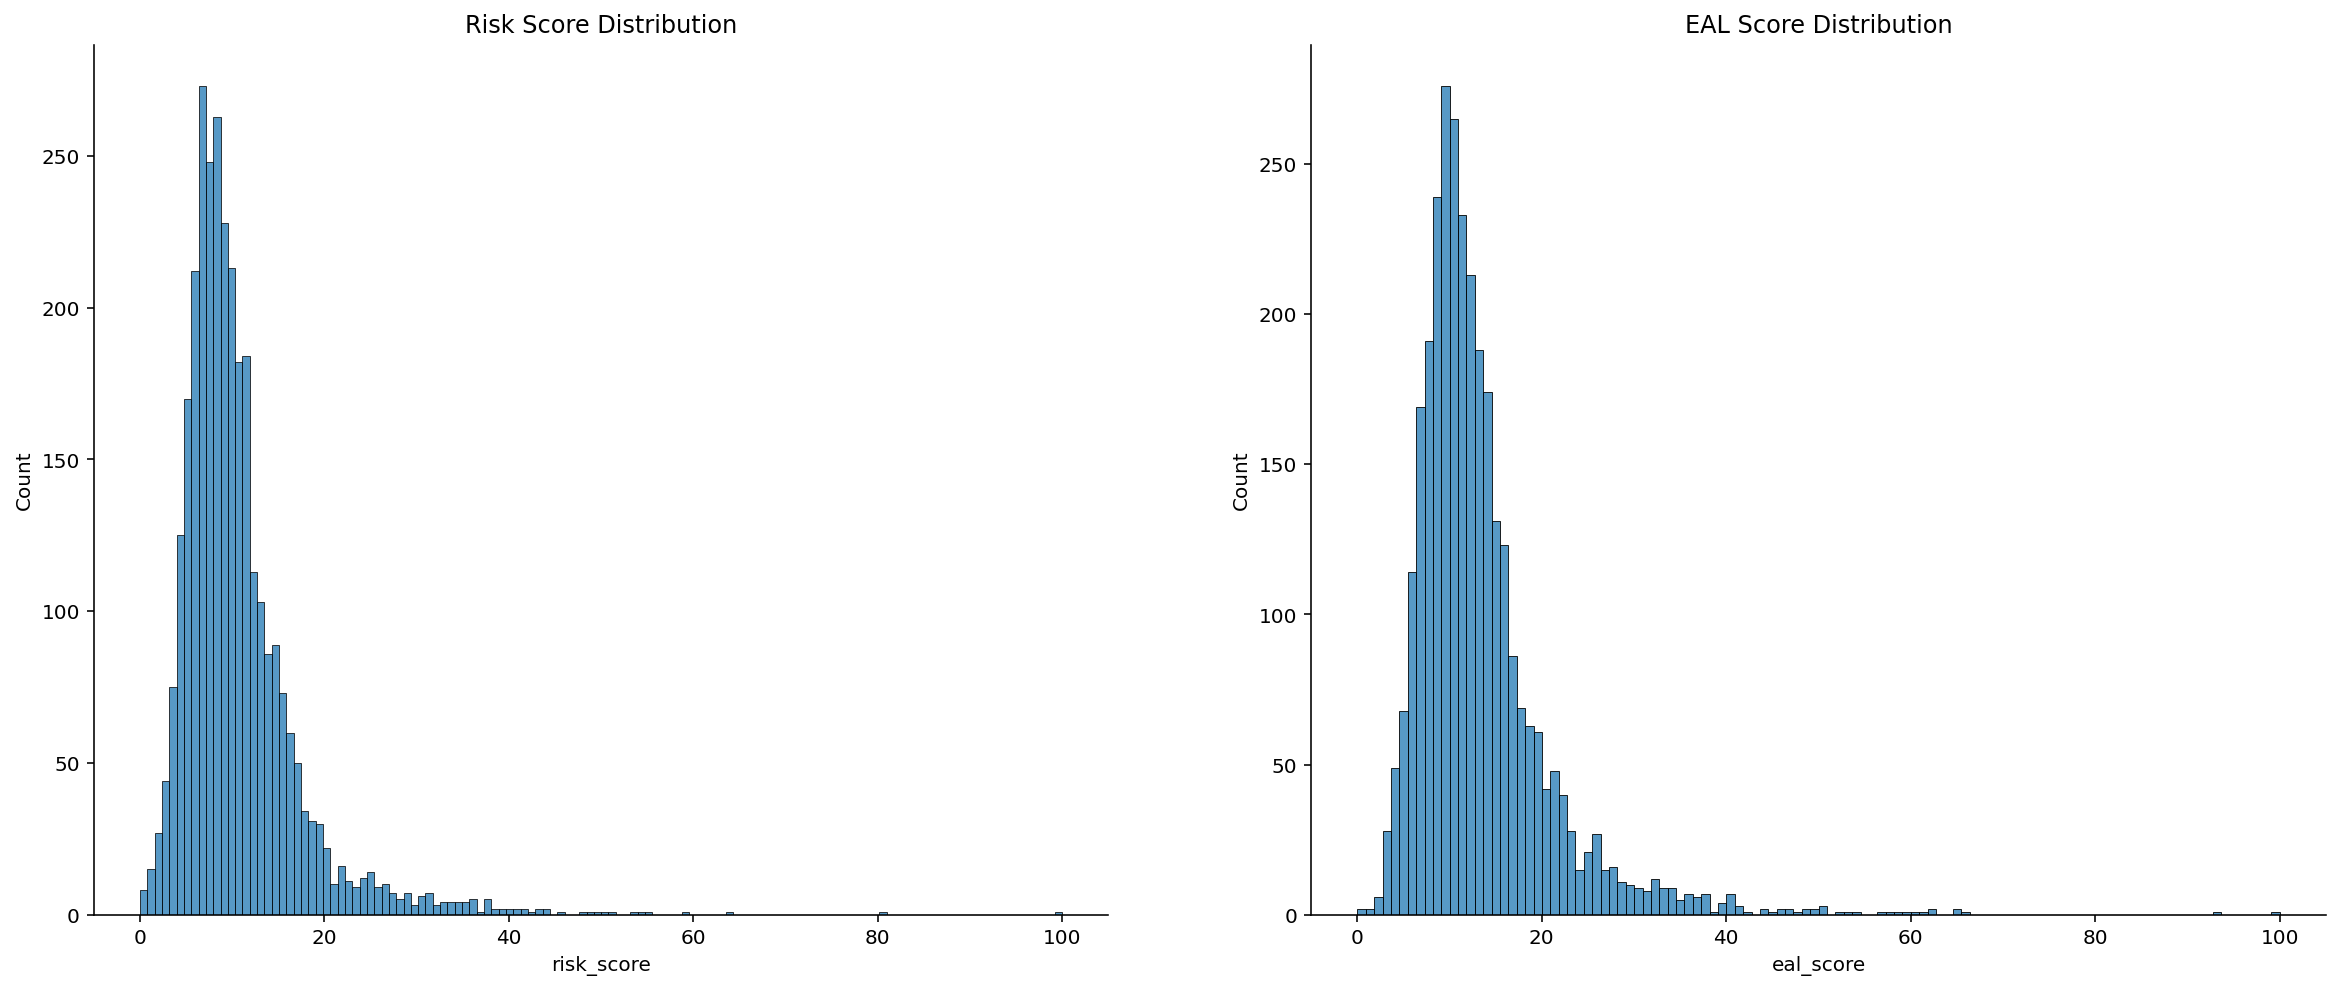

In [795]:
# get distribution of risk/eal score

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.histplot(x='risk_score', ax = ax1, data = df_nri)
sns.histplot(x='eal_score', ax = ax2, data = df_nri)

ax1.set_title('Risk Score Distribution')
ax2.set_title('EAL Score Distribution')

sns.despine()
plt.show()

For the most part, it seems like a fairly normal distribution. We can see that there is a slight right skew in both, so we will have to fix that before doing linear regression. 

In [796]:
df_nri['risk_score'].describe()

count    3142.000000
mean       10.603570
std         6.768475
min         0.000000
25%         6.689240
50%         9.089077
75%        12.533477
max       100.000000
Name: risk_score, dtype: float64

In [797]:
df_nri['eal_score'].describe()

count    3142.000000
mean       13.334561
std         7.736843
min         0.018372
25%         8.799945
50%        11.517427
75%        15.516319
max       100.000000
Name: eal_score, dtype: float64

#### The two distributions are right-skewed, so let's log-transform them.

In [798]:
# we do a log(x + .1) transformation because some x == 0 and we are unable to log those.
df_nri['risk_score_log10'] = np.log10(df_nri['risk_score'] + .1) 
df_nri['eal_score_log10'] = np.log10(df_nri['eal_score'] + .1) 

#### Let's see the log-transformed distributions.

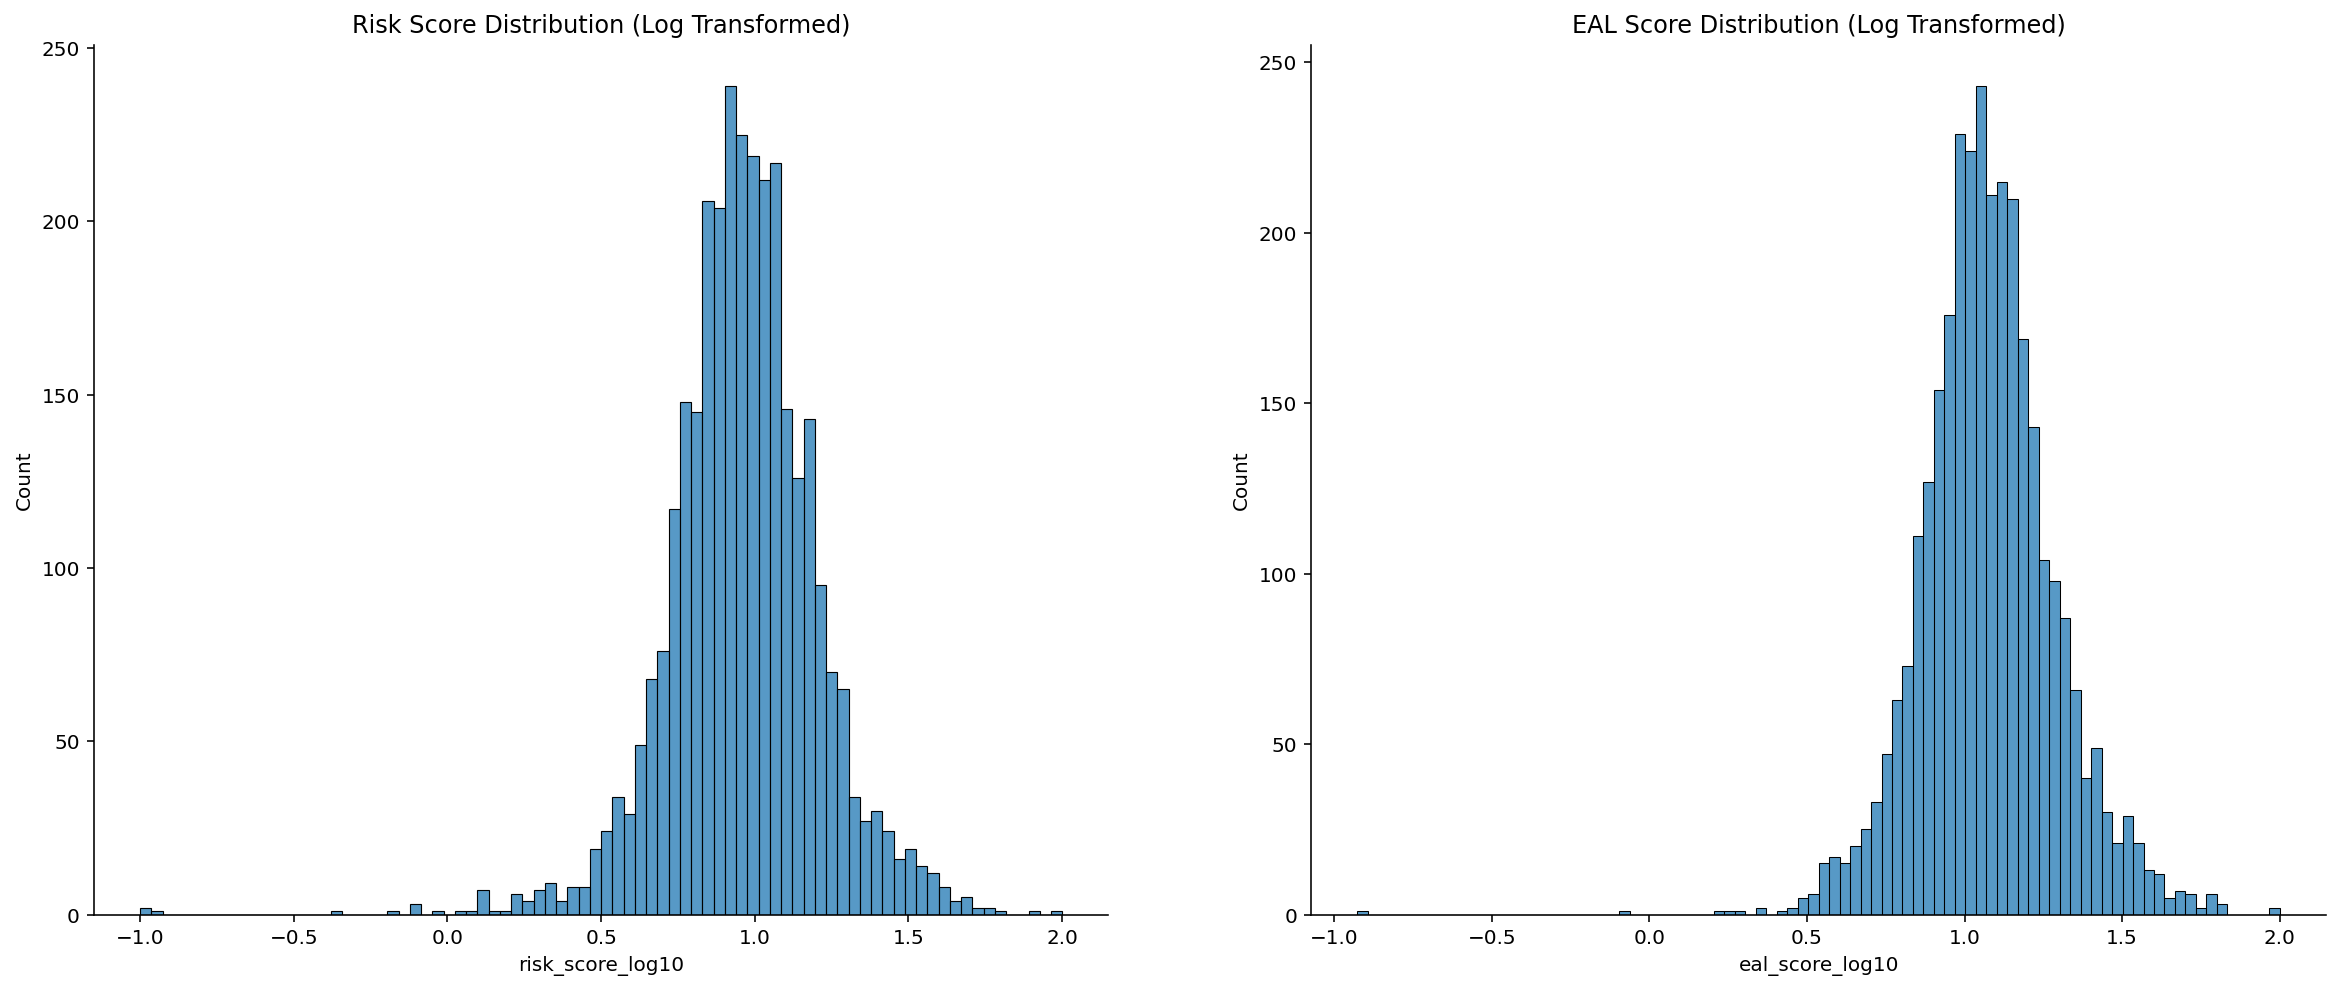

In [799]:
# get distribution of risk/eal score (log-transformed)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.histplot(x='risk_score_log10', ax = ax1, data = df_nri)
sns.histplot(x='eal_score_log10', ax = ax2, data = df_nri)

ax1.set_title('Risk Score Distribution (Log Transformed)')
ax2.set_title('EAL Score Distribution (Log Transformed)')

sns.despine()
plt.show()

### What's going on at the left-end of our distribution?
What counties are on the far left? What could be the reason?

In [800]:
df_nri[df_nri['risk_score_log10'] < -.5]

state state_abbrv state_fips         county county_fips  population  \
1479   Georgia          GA         13  Chattahoochee         053       11267   
2673     Texas          TX         48         Loving         301          82   
2902  Virginia          VA         51        Loudoun         107      312311   

            area  risk_score risk_rating  eal_score           eal_rating  \
1479  248.735663    0.009269    Very Low   4.693806             Very Low   
2673  668.751593    0.004606    Very Low   0.018372             Very Low   
2902  515.576847    0.000000    Very Low  17.339336  Relatively Moderate   

      sovi_score  resl_score   fips  risk_encoded  eal_encoded  \
1479    0.118250   49.330802  13053             1            1   
2673   18.880568   48.060598  48301             1            1   
2902    0.010000   53.638200  51107             1            3   

      risk_score_log10  eal_score_log10  
1479         -0.961504         0.680680  
2673         -0.980444        -0.926753  
2902         -1.000000         1.241530

In [801]:
df_nri[df_nri['eal_score_log10'] < -.5]

state state_abbrv state_fips  county county_fips  population  \
2673  Texas          TX         48  Loving         301          82   

            area  risk_score risk_rating  eal_score eal_rating  sovi_score  \
2673  668.751593    0.004606    Very Low   0.018372   Very Low   18.880568   

      resl_score   fips  risk_encoded  eal_encoded  risk_score_log10  \
2673   48.060598  48301             1            1         -0.980444   

      eal_score_log10  
2673        -0.926753

### Explanation
In Chattachoochee, GA, the frequency of natural disasters are well below the national average and the area is quite poor where around twenty percent of the population lives below the poverty line. These are among the many factors that contribute to low eal and risk scores.

We can see that Loving, TX is an outlier for both graphs. In fact, Loving, TX is the least populous county in all of the U.S and it consists of flat desert terrain with not much infrastructure. It makes sense that its eal and risk scores are low.  

For Loundon, VA, natural disasters rarely hit the area so its risk score is low. However, it is the richest county in the U.S, so its expected annual loss would be rated higher due to this fact.

### Which counties have the highest and lowest EAL score?

In [802]:
df_nri.sort_values(by = ['eal_score'], ascending = False)

state state_abbrv state_fips                 county county_fips  \
1271  California          CA         06            Los Angeles         037   
2623       Texas          TX         48                 Harris         201   
1295  California          CA         06            Santa Clara         085   
1285  California          CA         06              Riverside         065   
1253  California          CA         06                Alameda         001   
...          ...         ...        ...                    ...         ...   
222     Michigan          MI         26               Keweenaw         083   
1161      Alaska          AK         02               Wrangell         275   
1155      Alaska          AK         02  Prince of Wales-Hyder         198   
1615      Hawaii          HI         15                Kalawao         005   
2673       Texas          TX         48                 Loving         301   

      population         area  risk_score      risk_rating   eal_score  \
1271     9818605  4058.076752  100.000000        Very High  100.000000   
2623     4092459  1704.918916   80.618536        Very High   93.636473   
1295     1781642  1291.210369   22.951107  Relatively High   66.140195   
1285     2189641  7206.325086   58.865953        Very High   64.985716   
1253     1510271   737.476821   40.402820  Relatively High   64.799506   
...          ...          ...         ...              ...         ...   
222         2156   540.111622    1.863178         Very Low    1.842344   
1161        2369  2555.846403    2.229517         Very Low    1.743167   
1155        6172  5219.877753    1.633056         Very Low    1.511835   
1615          90    11.991403    1.636476         Very Low    0.704283   
2673          82   668.751593    0.004606         Very Low    0.018372   

     eal_rating  sovi_score  resl_score   fips  risk_encoded  eal_encoded  \
1271  Very High   44.895546   51.892200  06037             5            5   
2623  Very High   38.904218   52.227802  48201             5            5   
1295  Very High   15.845487   52.772998  06085             4            5   
1285  Very High   40.362633   51.501598  06065             5            5   
1253  Very High   28.852976   53.484202  06001             4            5   
...         ...         ...         ...    ...           ...          ...   
222    Very Low   46.708711   53.279400  26083             1            1   
1161   Very Low   50.808041   45.840402  02275             1            1   
1155   Very Low   43.279464   46.206998  02198             1            1   
1615   Very Low   84.824596   42.100200  15005             1            1   
2673   Very Low   18.880568   48.060598  48301             1            1   

      risk_score_log10  eal_score_log10  
1271          2.000434         2.000434  
2623          1.906973         1.971909  
1295          1.362692         1.821122  
1285          1.770601         1.813486  
1253          1.607485         1.812241  
...                ...              ...  
222           0.292960         0.288326  
1161          0.367266         0.265565  
1155          0.238813         0.207321  
1615          0.239669        -0.094591  
2673         -0.980444        -0.926753  

[3142 rows x 18 columns]

### What counties have the highest and lowest risk score?

In [803]:
df_nri.sort_values(by = ['risk_score'], ascending = False).head()

state state_abbrv state_fips       county county_fips  population  \
1271  California          CA         06  Los Angeles         037     9818605   
2623       Texas          TX         48       Harris         201     4092459   
1429     Florida          FL         12   Miami-Dade         086     2496435   
1285  California          CA         06    Riverside         065     2189641   
828     New York          NY         36        Bronx         005     1385108   

             area  risk_score risk_rating   eal_score           eal_rating  \
1271  4058.076752  100.000000   Very High  100.000000            Very High   
2623  1704.918916   80.618536   Very High   93.636473            Very High   
1429  1898.662364   63.926384   Very High   46.243703            Very High   
1285  7206.325086   58.865953   Very High   64.985716            Very High   
828     42.050624   55.547136   Very High   25.603947  Relatively Moderate   

      sovi_score  resl_score   fips  risk_encoded  eal_encoded  \
1271   44.895546   51.892200  06037             5            5   
2623   38.904218   52.227802  48201             5            5   
1429   63.854947   53.389602  12086             5            5   
1285   40.362633   51.501598  06065             5            5   
828    93.929838   50.042000  36005             5            3   

      risk_score_log10  eal_score_log10  
1271          2.000434         2.000434  
2623          1.906973         1.971909  
1429          1.806359         1.665991  
1285          1.770601         1.813486  
828           1.745443         1.410000

In [804]:
df_nri.sort_values(by = ['risk_score'], ascending = False).tail()

state state_abbrv state_fips         county county_fips  population  \
2929  Virginia          VA         51   Falls Church         610       12332   
1329  Colorado          CO         08        Douglas         035      285465   
1479   Georgia          GA         13  Chattahoochee         053       11267   
2673     Texas          TX         48         Loving         301          82   
2902  Virginia          VA         51        Loudoun         107      312311   

            area  risk_score risk_rating  eal_score           eal_rating  \
2929    1.985292    0.586229    Very Low   6.946532             Very Low   
1329  840.184666    0.341317    Very Low  20.669999  Relatively Moderate   
1479  248.735663    0.009269    Very Low   4.693806             Very Low   
2673  668.751593    0.004606    Very Low   0.018372             Very Low   
2902  515.576847    0.000000    Very Low  17.339336  Relatively Moderate   

      sovi_score  resl_score   fips  risk_encoded  eal_encoded  \
2929    4.178163   56.864600  51610             1            1   
1329    0.788333   54.585600  08035             1            3   
1479    0.118250   49.330802  13053             1            1   
2673   18.880568   48.060598  48301             1            1   
2902    0.010000   53.638200  51107             1            3   

      risk_score_log10  eal_score_log10  
2929         -0.163531         0.847975  
1329         -0.355249         1.317436  
1479         -0.961504         0.680680  
2673         -0.980444        -0.926753  
2902         -1.000000         1.241530

Here, we can see that Los Angeles, CA takes the number one spot in both categories. This makes sense because EAL is calculated via anticipated loss in both the economy and population, both of which LA has a large amounts of. Also, LA is hit with an abundance of wildfires and earthquakes, which (among other factors), influence risk score.

## Linear Regression
#### Before applying linear regression, let's take a look at our correlations and outliers.

<AxesSubplot:xlabel='risk_score', ylabel='eal_score'>

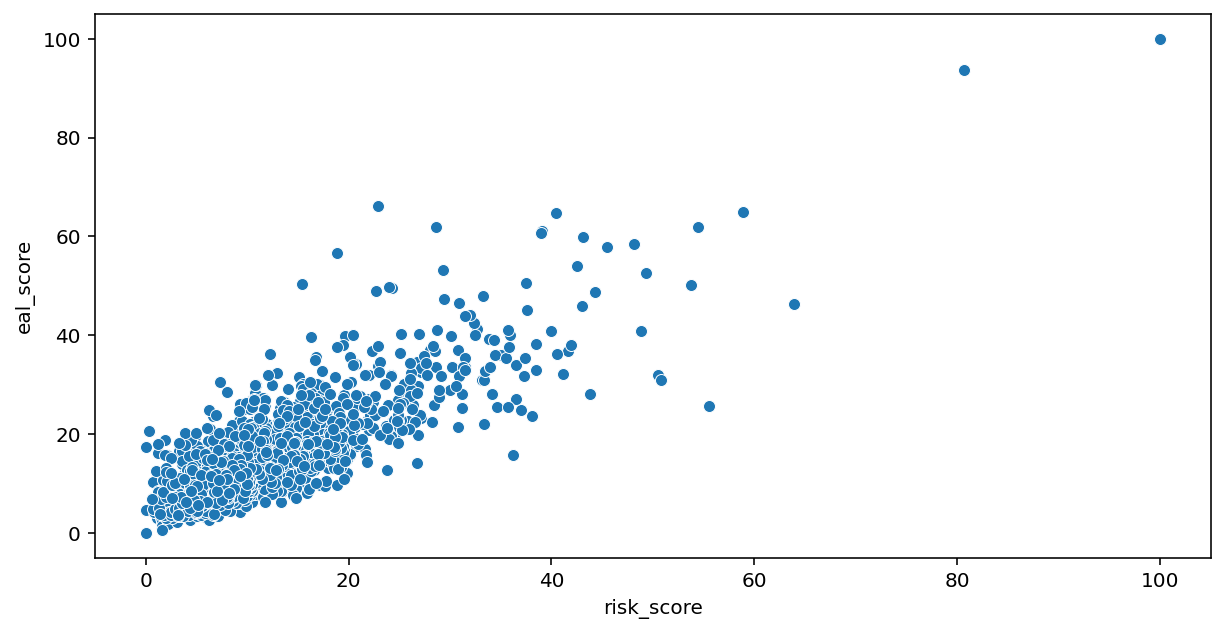

In [805]:
sns.scatterplot(x = 'risk_score', y = 'eal_score', data = df_nri)

### We can see that the most major outliers are the two on the far right. Let's find them.

In [806]:
outliers = df_nri[df_nri['risk_score'] > 80]
outliers

state state_abbrv state_fips       county county_fips  population  \
1271  California          CA         06  Los Angeles         037     9818605   
2623       Texas          TX         48       Harris         201     4092459   

             area  risk_score risk_rating   eal_score eal_rating  sovi_score  \
1271  4058.076752  100.000000   Very High  100.000000  Very High   44.895546   
2623  1704.918916   80.618536   Very High   93.636473  Very High   38.904218   

      resl_score   fips  risk_encoded  eal_encoded  risk_score_log10  \
1271   51.892200  06037             5            5          2.000434   
2623   52.227802  48201             5            5          1.906973   

      eal_score_log10  
1271         2.000434  
2623         1.971909

Los Angeles, CA is the most populous county is the US and Harris, TX is the third most populous county. Both are hit with natural disasters very frequently and both have a lot to lose when those disasters do strike.

### The scatter matrix
It is clear that there is a positive correlation between eal score and risk score

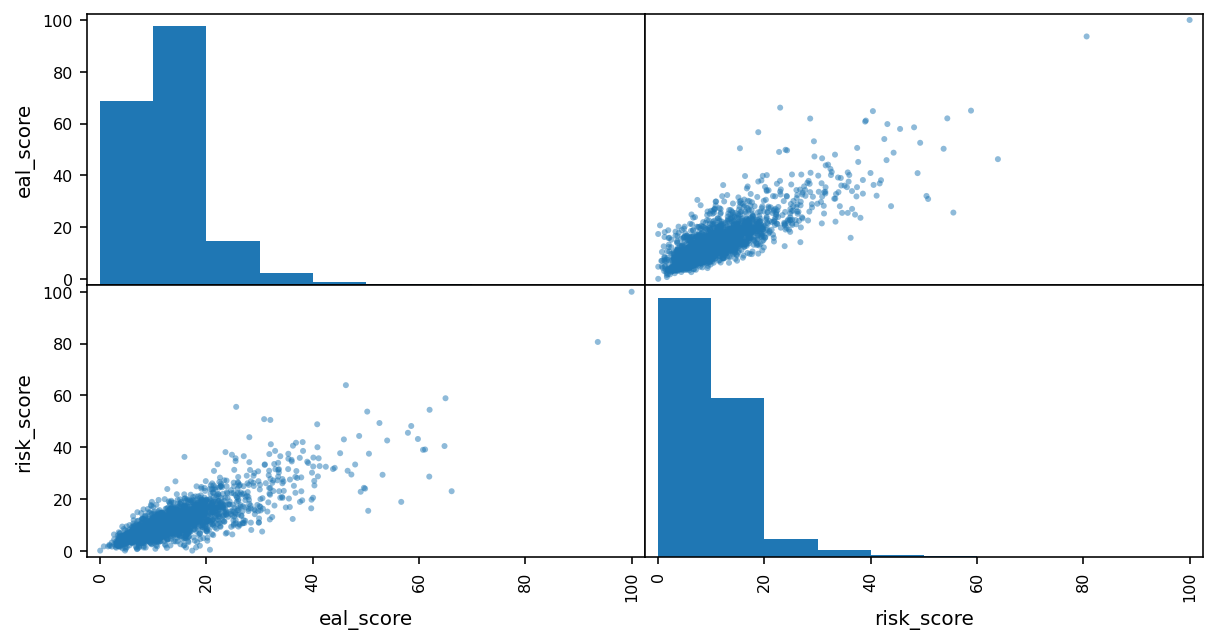

In [807]:
fig = pd.plotting.scatter_matrix(df_nri[['eal_score','risk_score']])

### We can use linear regression to see the correlation between risk_score and expected annual loss.

We will use the log-transformed values.

In [808]:
outcome, predictors = patsy.dmatrices('risk_score_log10 ~ eal_score_log10', df_nri)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       risk_score_log10   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     4481.
Date:                Sat, 12 Mar 2022   Prob (F-statistic):               0.00
Time:                        01:58:08   Log-Likelihood:                 1382.7
No. Observations:                3142   AIC:                            -2761.
Df Residuals:                    3140   BIC:                            -2749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0255      0.014     

##### By our adjusted r-squared, we can see that there is a correlation between risk and expected annual loss in a county.

## Let's create a choropleth of all counties risk_score in the US

In [809]:
# we need state and county FIPS information (already included in NRI dataset)
df_nri['state_fips'] = df_nri['state_fips'].apply(lambda x: str(x).zfill(2))
df_nri['county_fips'] = df_nri['county_fips'].apply(lambda x: str(x).zfill(3))
df_nri['fips'] = df_nri['state_fips'] + df_nri['county_fips']

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

### Choropleth for risk score

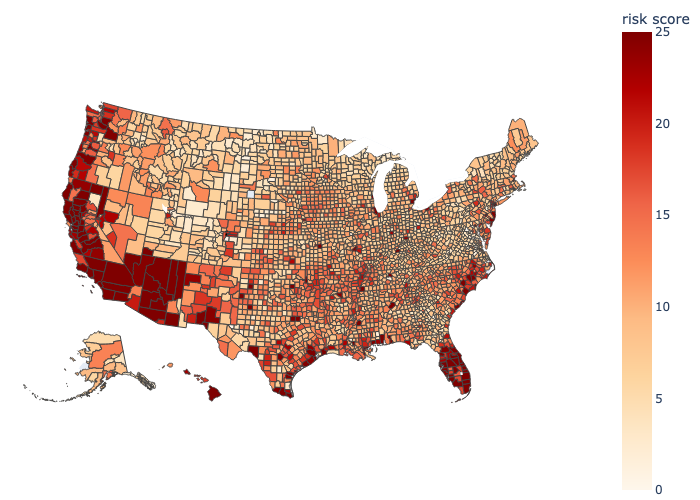

In [810]:
# View the color options below
# https://plotly.com/python/builtin-colorscales/

fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='risk_score',
                           color_continuous_scale="OrRd",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'risk_score':'risk score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("images/risk_choropleth.png")
Image(filename='images/risk_choropleth.png') 


### Choropleth for eal score

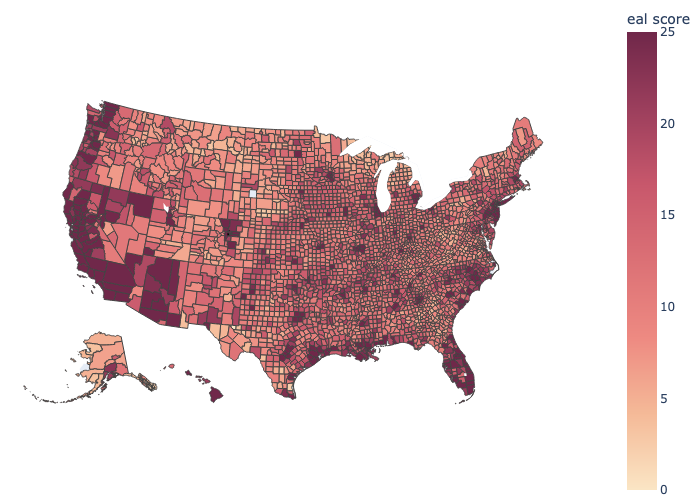

In [811]:
fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='eal_score',
                           color_continuous_scale="Burgyl",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'eal_score':'eal score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_image("images/eal_choropleth.png")
Image(filename='images/eal_choropleth.png') 

# EDA on Housing Price vs. Risk Score and Expected Annual Loss Score

Let's merge the housing price and National Risk Index dataframes for this EDA.

In [812]:
df_housing = pd.read_csv('datasets/cleaned/NewHousingPrices2017-2021.csv')
df_nri = pd.read_csv('datasets/cleaned/nri.csv').rename(columns = {"fips":"FIPS"})

df_housing_nri_merged = pd.merge(df_housing, df_nri, how ='outer', on =['FIPS'])
df_housing_nri_merged.dropna(how='any', inplace = True)

df_housing_nri_merged['FIPS'] = df_housing_nri_merged['FIPS'].apply(lambda x: str(x))
df_housing_nri_merged['FIPS'] = df_housing_nri_merged['FIPS'].apply(lambda x: x.zfill(5))
df_housing_nri_merged.head()

County & State   FIPS      2017      2018      2019      2020  \
0  Autauga County,  Alabama  01001  145203.0  144361.0  153716.0  160972.0   
1  Baldwin County,  Alabama  01003  185313.0  205764.0  209494.0  232730.0   
2  Barbour County,  Alabama  01005   97533.0   91965.0  100423.0   94615.0   
3     Bibb County,  Alabama  01007  116052.0  110683.0  101799.0   97807.0   
4   Blount County,  Alabama  01009  135375.0  128203.0  131548.0  134696.0   

       2021    state state_abbrv  state_fips  ... population         area  \
0  166318.0  Alabama          AL           1  ...      54571   594.448312   
1  243643.0  Alabama          AL           1  ...     182265  1589.815853   
2   99052.0  Alabama          AL           1  ...      27457   885.001636   
3  102324.0  Alabama          AL           1  ...      22915   622.460425   
4  140916.0  Alabama          AL           1  ...      57322   644.821022   

   risk_score          risk_rating  eal_score           eal_rating  \
0    5.748777             Very Low  10.687727       Relatively Low   
1   13.557905  Relatively Moderate  18.735079  Relatively Moderate   
2    9.419639       Relatively Low  11.935457       Relatively Low   
3    4.346314             Very Low   9.076046             Very Low   
4    9.362945       Relatively Low  14.548375       Relatively Low   

   sovi_score resl_score  risk_encoded  eal_encoded  
0   25.857312  55.529800             1            2  
1   34.292471  54.759202             3            3  
2   34.686638  50.781998             2            2  
3   21.482065  51.807600             1            1  
4   29.720142  53.357400             2            2  

[5 rows x 22 columns]

## Distributions
We will take a look at how our housing price is distributed among counties in the US

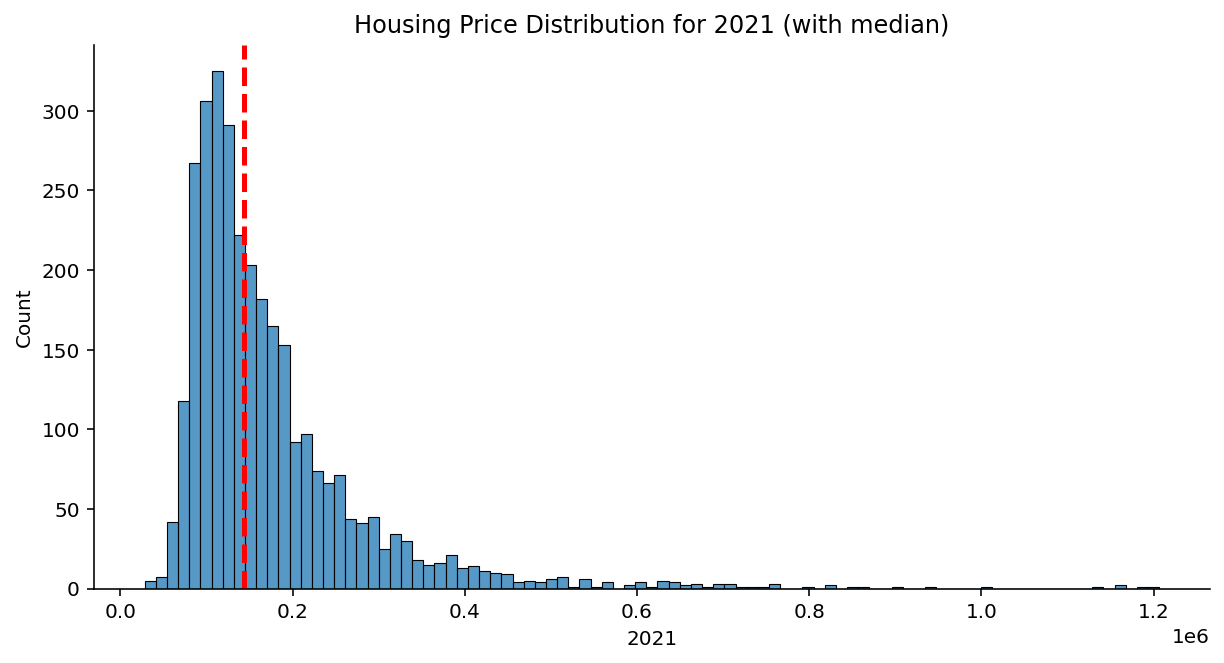

In [813]:
# get distribution of housing price

sns.histplot(x='2021', data = df_housing_nri_merged).set_title('Housing Price Distribution for 2021 (with median)')
plt.axvline(x=df_housing_nri_merged['2021'].median(),
            color='red', ls='--', lw=2.5)
sns.despine()

There is a right skew so let's boxcox transform the data so that we can apply regression.

## Boxcox Transforming Our 2021 Housing Prices

In [814]:
fitted_data, fitted_lambda = boxcox(df_housing_nri_merged['2021'])
df_housing_nri_merged['2021_boxcox'] = fitted_data
df_housing_nri_merged.head()

County & State   FIPS      2017      2018      2019      2020  \
0  Autauga County,  Alabama  01001  145203.0  144361.0  153716.0  160972.0   
1  Baldwin County,  Alabama  01003  185313.0  205764.0  209494.0  232730.0   
2  Barbour County,  Alabama  01005   97533.0   91965.0  100423.0   94615.0   
3     Bibb County,  Alabama  01007  116052.0  110683.0  101799.0   97807.0   
4   Blount County,  Alabama  01009  135375.0  128203.0  131548.0  134696.0   

       2021    state state_abbrv  state_fips  ...         area  risk_score  \
0  166318.0  Alabama          AL           1  ...   594.448312    5.748777   
1  243643.0  Alabama          AL           1  ...  1589.815853   13.557905   
2   99052.0  Alabama          AL           1  ...   885.001636    9.419639   
3  102324.0  Alabama          AL           1  ...   622.460425    4.346314   
4  140916.0  Alabama          AL           1  ...   644.821022    9.362945   

           risk_rating  eal_score           eal_rating sovi_score  resl_score  \
0             Very Low  10.687727       Relatively Low  25.857312   55.529800   
1  Relatively Moderate  18.735079  Relatively Moderate  34.292471   54.759202   
2       Relatively Low  11.935457       Relatively Low  34.686638   50.781998   
3             Very Low   9.076046             Very Low  21.482065   51.807600   
4       Relatively Low  14.548375       Relatively Low  29.720142   53.357400   

  risk_encoded  eal_encoded  2021_boxcox  
0            1            2     2.196748  
1            3            3     2.198255  
2            2            2     2.194235  
3            1            1     2.194411  
4            2            2     2.196007  

[5 rows x 23 columns]

Take a look at the distribution now.

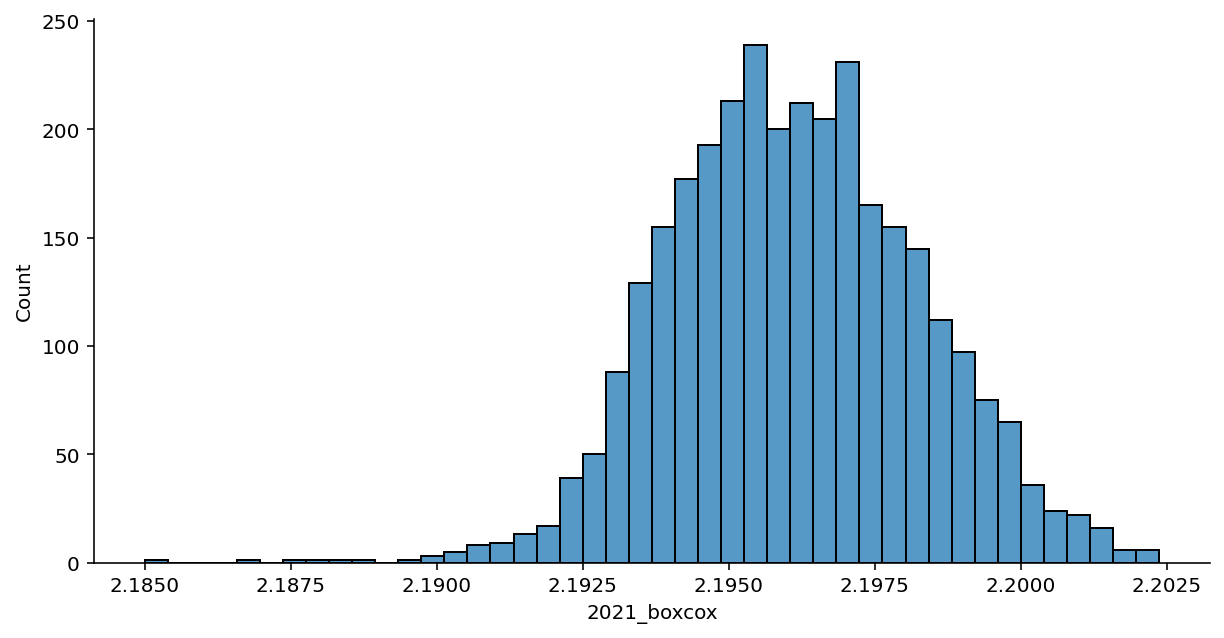

In [815]:
# get distribution of housing price

sns.histplot(x='2021_boxcox', data = df_housing_nri_merged)
ax1.set_title('Housing Price Distribution (2021)')
sns.despine()

Now we have a normal distribution which we will use for regression later.

### Which counties have the highest and lowest housing prices in 2021?

In [816]:
df_housing_nri_merged.sort_values(by = ['2021'], ascending = False).head()

County & State   FIPS       2017       2018  \
1851         New York County,  New York  36061   928301.0  1022410.0   
1207   Nantucket County,  Massachusetts  25019   977083.0  1066641.0   
221     Santa Clara County,  California  06085   939597.0  1081779.0   
219       San Mateo County,  California  06081  1050406.0  1205405.0   
216   San Francisco County,  California  06075  1077650.0  1224255.0   

           2019       2020       2021          state state_abbrv  state_fips  \
1851  1055711.0  1158975.0  1206529.0       New York          NY          36   
1207  1105814.0  1090267.0  1188144.0  Massachusetts          MA          25   
221   1089740.0  1123226.0  1159910.0     California          CA           6   
219   1195477.0  1150016.0  1155499.0     California          CA           6   
216   1182325.0  1135007.0  1140419.0     California          CA           6   

      ...         area  risk_score          risk_rating  eal_score  \
1851  ...    22.656978   34.177655      Relatively High  28.080777   
1207  ...    46.112811    1.131330             Very Low   3.030702   
221   ...  1291.210369   22.951107      Relatively High  66.140195   
219   ...   448.556757   22.750567  Relatively Moderate  49.029219   
216   ...    46.905643   33.270781      Relatively High  47.986907   

           eal_rating sovi_score  resl_score risk_encoded  eal_encoded  \
1851  Relatively High  53.724872   51.016402            4            4   
1207         Very Low  18.328735   56.567798            1            1   
221         Very High  15.845487   52.772998            4            5   
219         Very High  21.679149   53.994398            3            5   
216         Very High  30.469058   50.790802            4            5   

      2021_boxcox  
1851     2.202371  
1207     2.202344  
221      2.202302  
219      2.202295  
216      2.202272  

[5 rows x 23 columns]

In [817]:
df_housing_nri_merged.sort_values(by = ['2021'], ascending = False).tail()

County & State   FIPS     2017     2018     2019  \
2640              King County,  Texas  48269  84024.0  41127.0  40460.0   
2637              Kent County,  Texas  48263  83217.0  74729.0  41938.0   
2999  McDowell County,  West Virginia  54047  37778.0  35632.0  35192.0   
2385   Mellette County,  South Dakota  46095  57028.0  46984.0  46644.0   
2395       Todd County,  South Dakota  46121  50755.0  39931.0  35114.0   

         2020     2021          state state_abbrv  state_fips  ...  \
2640  38388.0  40531.0          Texas          TX          48  ...   
2637  36610.0  38654.0          Texas          TX          48  ...   
2999  36558.0  37358.0  West Virginia          WV          54  ...   
2385  32911.0  34704.0   South Dakota          SD          46  ...   
2395  26657.0  28109.0   South Dakota          SD          46  ...   

             area  risk_score          risk_rating  eal_score      eal_rating  \
2640   910.872076    4.415355             Very Low   5.087641        Very Low   
2637   902.506479    7.386888             Very Low   6.300662        Very Low   
2999   533.456630   17.076402  Relatively Moderate  13.667560  Relatively Low   
2385  1307.325748    6.668241             Very Low   5.420596        Very Low   
2395  1388.527610   15.938889  Relatively Moderate   8.173543        Very Low   

     sovi_score  resl_score risk_encoded  eal_encoded  2021_boxcox  
2640  40.047300   53.293200            1            1     2.188242  
2637  55.222704   54.417400            1            1     2.187852  
2999  52.227040   48.307000            3            2     2.187565  
2385  61.411115   57.670598            1            1     2.186931  
2395  88.726843   52.579998            3            1     2.184996  

[5 rows x 23 columns]

## Choropleth for 2021 housing prices

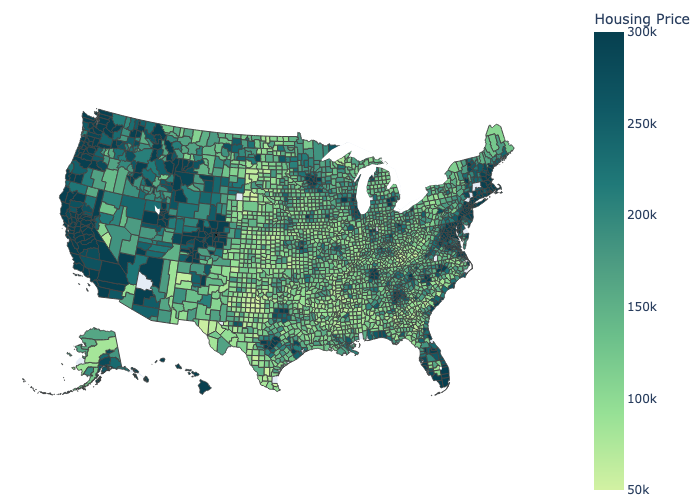

In [818]:
fig = px.choropleth(df_housing_nri_merged, geojson=counties, locations='FIPS', color='2021',
                           color_continuous_scale="Emrld",
                           range_color=(50000, 300000),
                           scope="usa",
                           labels={'2021':'Housing Price'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("images/housing_choropleth.png")
Image(filename='images/housing_choropleth.png') 

## Relationships & Correlations

Let's see the scatter matrix between risk score, expected annual loss, and 2021 housing prices to get a better sense of our relationships.

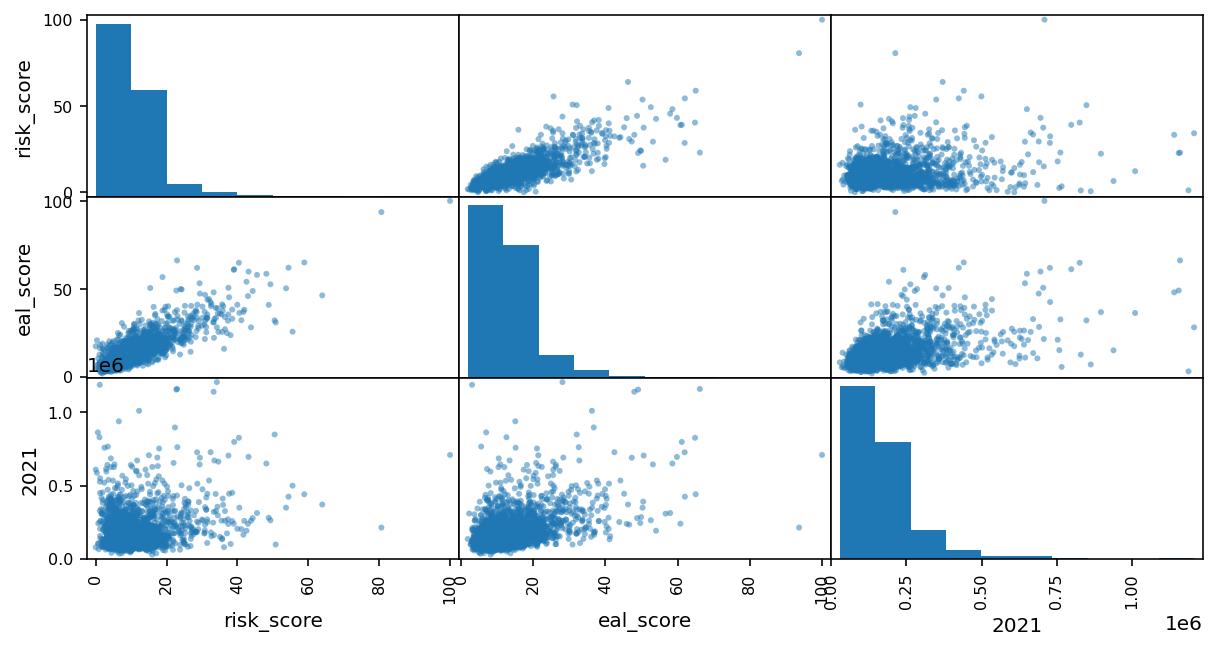

In [819]:
fig = pd.plotting.scatter_matrix(df_housing_nri_merged[['risk_score', 'eal_score', '2021']])

In [820]:
def annotate(data, column, year, x, y, **kws):
    r, p = pearsonr(data[column], data[year])
    ax = plt.gca()
    ax.text(x, y, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, weight='bold', size='x-large')

### Risk Score and Housing Prices

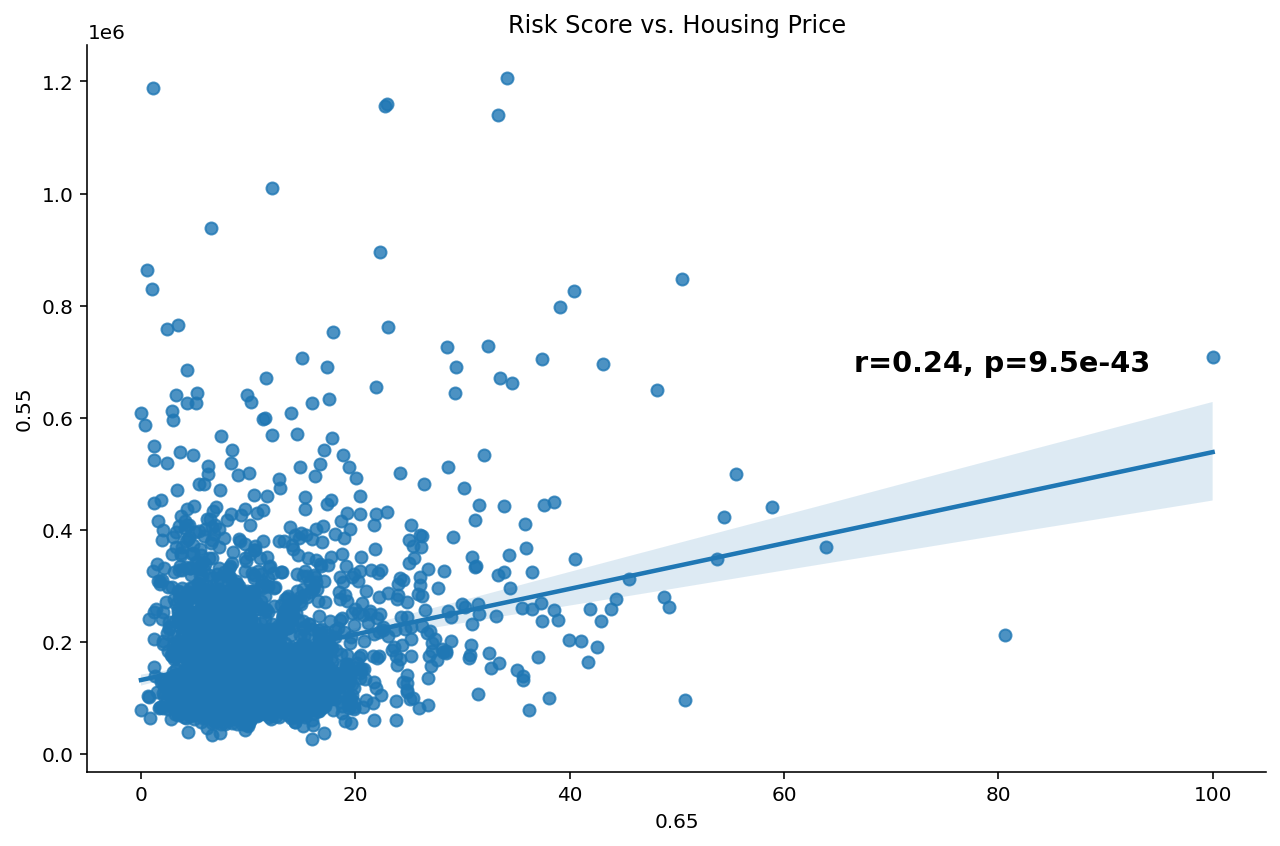

In [821]:
plot = sns.lmplot(x = 'risk_score', y = '2021', height = 6, aspect=1.5,data = df_housing_nri_merged)
plt.xlabel('Risk Score')
plt.ylabel('Housing Price (USD)')
plt.title('Risk Score vs. Housing Price')
plot.map_dataframe(annotate, column='risk_score', year='2021', x=.65, y=.55)


sns.despine()

Interesting, there seems to be either a weak positive correlation between housing prices and risk score. We can see that there are some counties with a low risk score and a high housing price. Let's now take a look at those counties.

In [822]:
df_housing_nri_merged[(df_housing_nri_merged['2021'] >= 900000) & (df_housing_nri_merged['risk_score'] < 30)]

County & State   FIPS       2017       2018  \
199          Marin County,  California  06041  1037699.0  1124350.0   
219      San Mateo County,  California  06081  1050406.0  1205405.0   
221    Santa Clara County,  California  06085   939597.0  1081779.0   
1207  Nantucket County,  Massachusetts  25019   977083.0  1066641.0   
3112            Teton County,  Wyoming  56039   746088.0   769415.0   

           2019       2020       2021          state state_abbrv  state_fips  \
199   1059218.0  1005705.0  1010500.0     California          CA           6   
219   1195477.0  1150016.0  1155499.0     California          CA           6   
221   1089740.0  1123226.0  1159910.0     California          CA           6   
1207  1105814.0  1090267.0  1188144.0  Massachusetts          MA          25   
3112   867907.0   894286.0   938682.0        Wyoming          WY          56   

      ...         area  risk_score          risk_rating  eal_score  \
199   ...   520.456551   12.228515       Relatively Low  36.235953   
219   ...   448.556757   22.750567  Relatively Moderate  49.029219   
221   ...  1291.210369   22.951107      Relatively High  66.140195   
1207  ...    46.112811    1.131330             Very Low   3.030702   
3112  ...  3996.855337    6.513988             Very Low  15.004361   

           eal_rating sovi_score  resl_score risk_encoded  eal_encoded  \
199   Relatively High  15.806070   54.121800            2            4   
219         Very High  21.679149   53.994398            3            5   
221         Very High  15.845487   52.772998            4            5   
1207         Very Low  18.328735   56.567798            1            1   
3112   Relatively Low  19.511234   51.918402            1            2   

      2021_boxcox  
199      2.202048  
219      2.202295  
221      2.202302  
1207     2.202344  
3112     2.201906  

[5 rows x 23 columns]

### EAL Score and Housing Prices

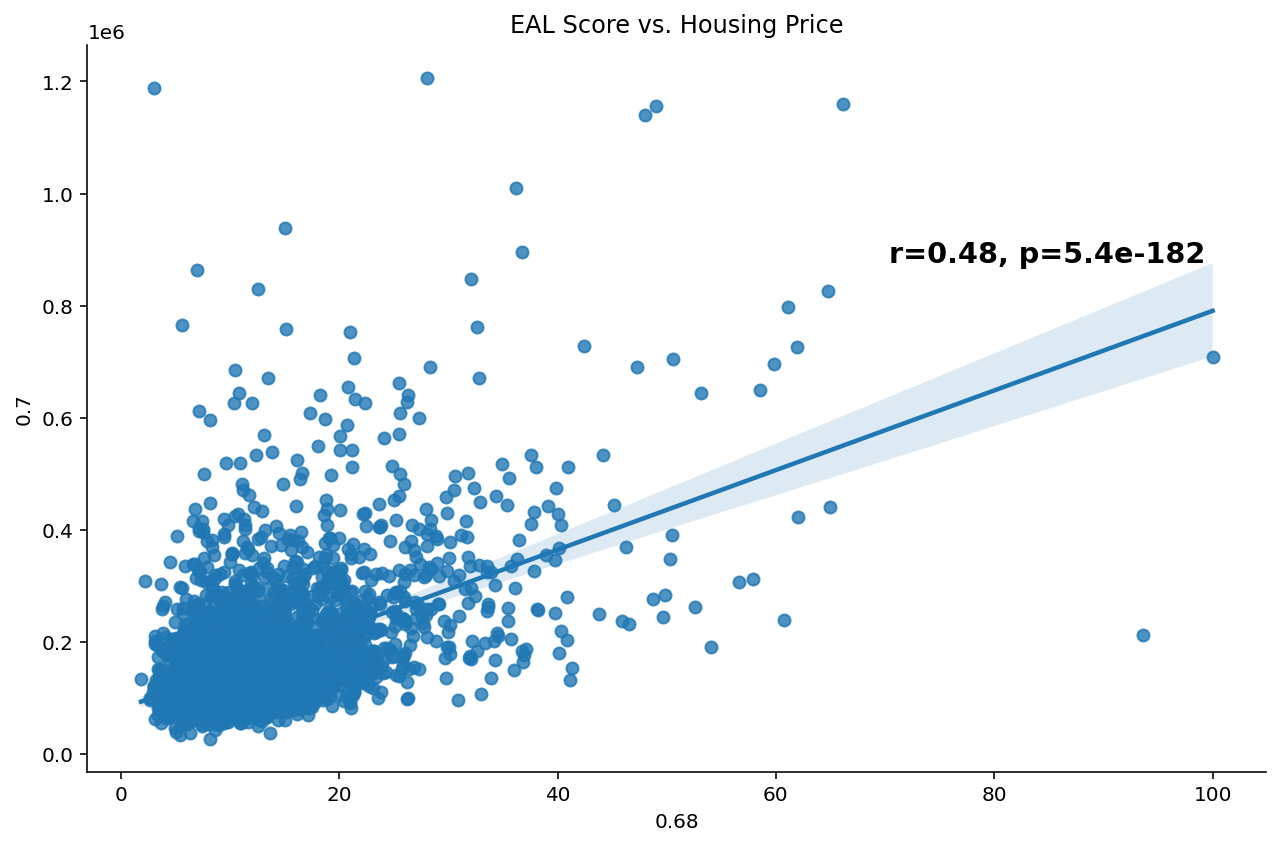

In [823]:
plot = sns.lmplot(x = 'eal_score', y = '2021', height = 6, aspect=1.5,data = df_housing_nri_merged)
plt.xlabel('EAL Score')
plt.ylabel('Housing Price (USD)')
plt.title('EAL Score vs. Housing Price')
plot.map_dataframe(annotate, column='eal_score', year='2021', x=.68, y=.7)
sns.despine()

Great! We see that there is a moderately positive correlation between EAL score and housing prices

## Linear Regression(s)

We can find statistical signifance between the two variables using a linear regression. We will use our transformed values (boxcox, log 10) in this analysis.

In [824]:
# we do a log(x + .1) transformation because some x == 0 and we are unable to log those.
df_housing_nri_merged['risk_score_log10'] = np.log10(df_housing_nri_merged['risk_score'] + .1) 
df_housing_nri_merged['eal_score_log10'] = np.log10(df_housing_nri_merged['eal_score'] + .1) 

### Regression on Risk Score for 2021

In [825]:
outcome, predictors = patsy.dmatrices('Q("2021_boxcox") ~ risk_score_log10', df_housing_nri_merged)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       Q("2021_boxcox")   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.33
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           0.000266
Time:                        01:58:26   Log-Likelihood:                 14765.
No. Observations:                3117   AIC:                        -2.953e+04
Df Residuals:                    3115   BIC:                        -2.951e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.1956      0.000  

### Regression on Expected Annual Loss Score for 2021

In [826]:
outcome, predictors = patsy.dmatrices('Q("2021_boxcox") ~ eal_score_log10', df_housing_nri_merged)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       Q("2021_boxcox")   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     641.8
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          6.61e-129
Time:                        01:58:26   Log-Likelihood:                 15051.
No. Observations:                3117   AIC:                        -3.010e+04
Df Residuals:                    3115   BIC:                        -3.009e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1916      0.000    1

We can see by our analysis that our adjusted r-squared is 0.171 which indicates a weak positive correlation between expected annual loss score and housing price. Our confidence interval does not include the null hypothesis so we can state that there is a statistical relationship between the two.

### Combining Both Risk Score and EAL Score in our Regression.

In [827]:
outcome, predictors = patsy.dmatrices('Q("2021_boxcox") ~ eal_score_log10 + risk_score_log10', df_housing_nri_merged)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       Q("2021_boxcox")   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     721.7
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          2.98e-258
Time:                        01:58:27   Log-Likelihood:                 15352.
No. Observations:                3117   AIC:                        -3.070e+04
Df Residuals:                    3114   BIC:                        -3.068e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.1917      0.000  

We can see that our adjusted r-squared jumped to 0.316, so expected annual loss score and risk score combined have a stronger correlation to housng prices than each of them individually.

## Correlations for 2017-2021
Note: This is Pearson R and not R-Squared (as shown from the Linear Regression)

In [828]:
fitted_data, fitted_lambda = boxcox(df_housing_nri_merged['2017'])
df_housing_nri_merged['2017_boxcox'] = fitted_data

fitted_data, fitted_lambda = boxcox(df_housing_nri_merged['2018'])
df_housing_nri_merged['2018_boxcox'] = fitted_data

fitted_data, fitted_lambda = boxcox(df_housing_nri_merged['2019'])
df_housing_nri_merged['2019_boxcox'] = fitted_data

fitted_data, fitted_lambda = boxcox(df_housing_nri_merged['2020'])
df_housing_nri_merged['2020_boxcox'] = fitted_data

### Pearson R for Risk Score

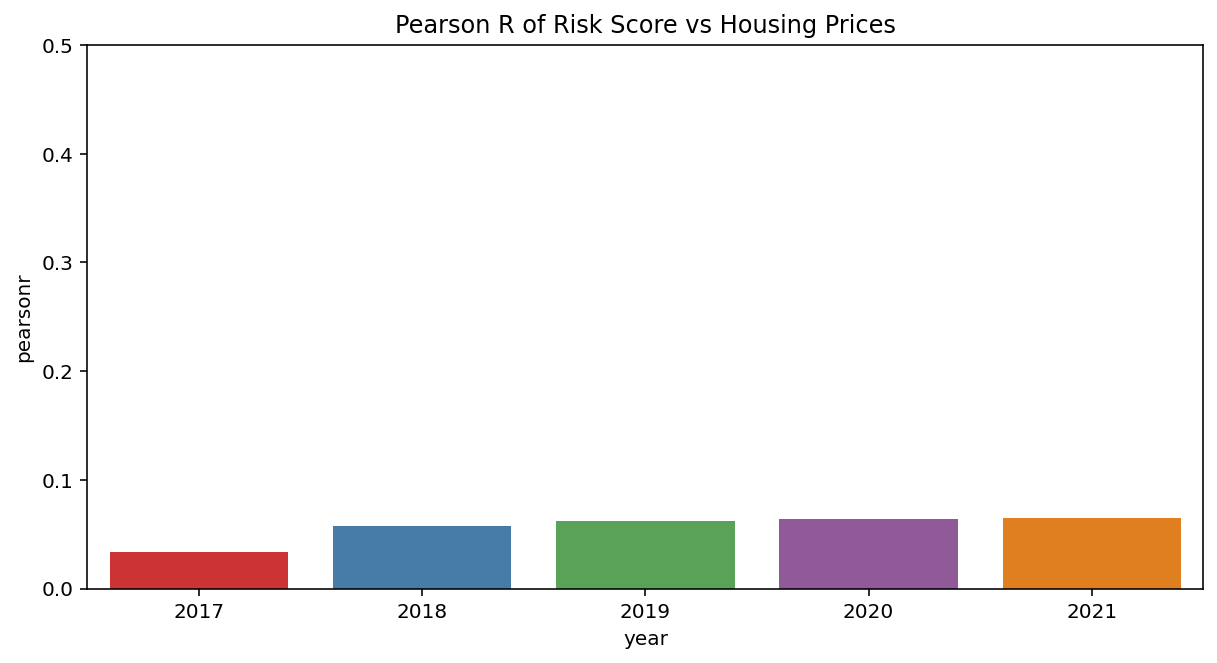

In [829]:
r_2017, p_2017 = pearsonr(df_housing_nri_merged['2017_boxcox'], df_housing_nri_merged['risk_score_log10'])
r_2018, p_2018 = pearsonr(df_housing_nri_merged['2018_boxcox'], df_housing_nri_merged['risk_score_log10'])
r_2019, p_2019 = pearsonr(df_housing_nri_merged['2019_boxcox'], df_housing_nri_merged['risk_score_log10'])
r_2020, p_2020 = pearsonr(df_housing_nri_merged['2020_boxcox'], df_housing_nri_merged['risk_score_log10'])
r_2021, p_2021 = pearsonr(df_housing_nri_merged['2021_boxcox'], df_housing_nri_merged['risk_score_log10'])
df_pearsonr = pd.DataFrame({'year':['2017', '2018', '2019', '2020', '2021'], 'pearsonr':[r_2017, r_2018, r_2019, r_2020, r_2021]})

sns.barplot(x='year', y='pearsonr', palette="Set1", data = df_pearsonr).set_title('Pearson R of Risk Score vs Housing Prices')
plt.ylim(0, .5)
plt.show()

Historically, we can see that risk score is not correlated with housing prices. We can conclude that 2021 (along with years following COVID), had little to no effect on this analysis.

### Pearson R for EAL

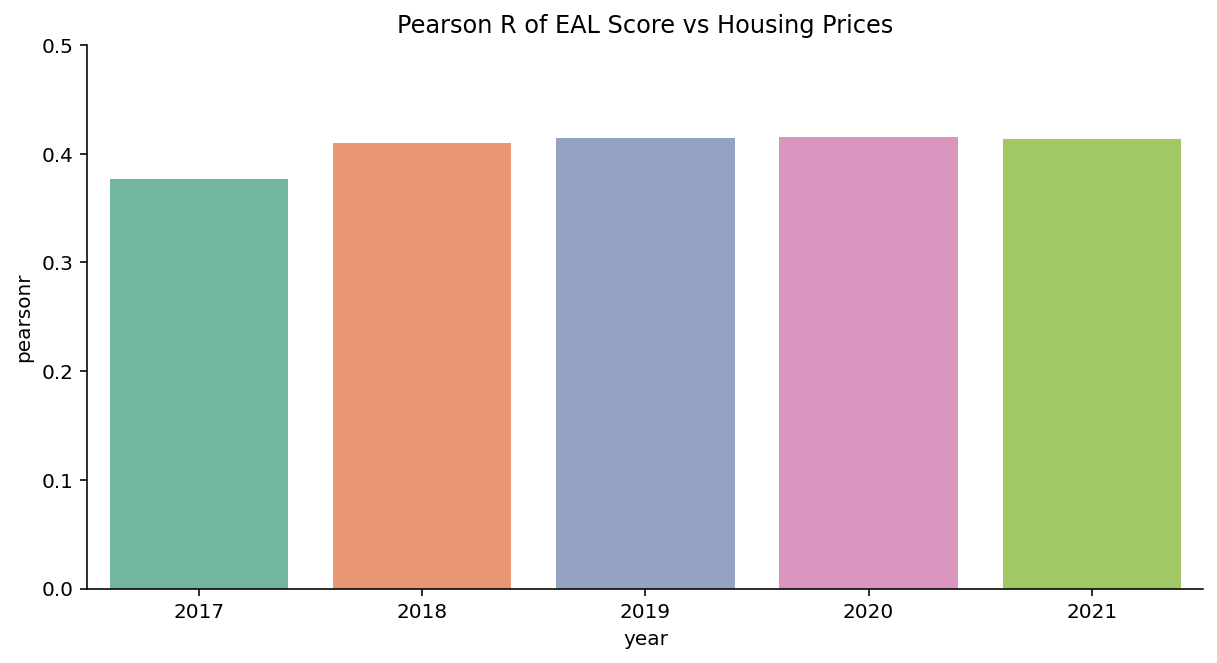

In [830]:
r_2017, p_2017 = pearsonr(df_housing_nri_merged['2017_boxcox'], df_housing_nri_merged['eal_score_log10'])
r_2018, p_2018 = pearsonr(df_housing_nri_merged['2018_boxcox'], df_housing_nri_merged['eal_score_log10'])
r_2019, p_2019 = pearsonr(df_housing_nri_merged['2019_boxcox'], df_housing_nri_merged['eal_score_log10'])
r_2020, p_2020 = pearsonr(df_housing_nri_merged['2020_boxcox'], df_housing_nri_merged['eal_score_log10'])
r_2021, p_2021 = pearsonr(df_housing_nri_merged['2021_boxcox'], df_housing_nri_merged['eal_score_log10'])
df_pearsonr = pd.DataFrame({'year':['2017', '2018', '2019', '2020', '2021'], 'pearsonr':[r_2017, r_2018, r_2019, r_2020, r_2021]})

sns.barplot(x='year', y='pearsonr', palette="Set2", data = df_pearsonr).set_title('Pearson R of EAL Score vs Housing Prices')
plt.ylim(0, .5)
sns.despine()
plt.show()

We see that the Expected Annual Loss score has been positively correlated with housing prices for the past 5 years. In addition, risk score has been weakly correlated with housing prices, if at all.

## EDA on Climate vs. Housing Prices

We created a Choropleth Map for Average Climate by County to help visualize climates across the United States

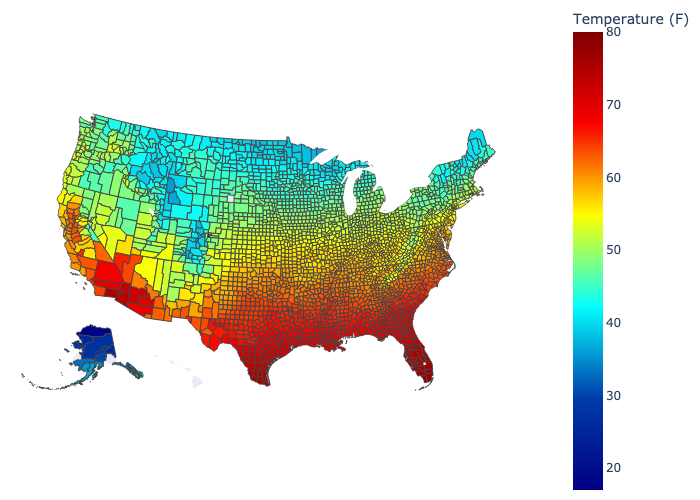

In [831]:
#Choropleth map by county for Climate
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
fig = px.choropleth(climate_df, geojson=counties, locations='fips', color='Temperature (F)',
                           color_continuous_scale="Jet",
                           range_color=(17, 80),
                           scope="usa",
                           labels={'Temperature (F)':'Temperature (F)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_image("images/climate_choropleth.png")
Image(filename='images/climate_choropleth.png') 

Before we perform a linear regression on our data, we first create some histograms to help visualize the data we are working with.

In [832]:
print("2017 min: $" + str(housing_climate_df['2017'].min()))
print("2017 max: $" + str(housing_climate_df['2017'].max()))
print("2021 min: $" + str(housing_climate_df['2021'].min()))
print("2021 max: $" + str(housing_climate_df['2021'].max()))

2017 min: $37177
2017 max: $1077650
2021 min: $28109
2021 max: $1206529


<AxesSubplot:xlabel='2017', ylabel='Count'>

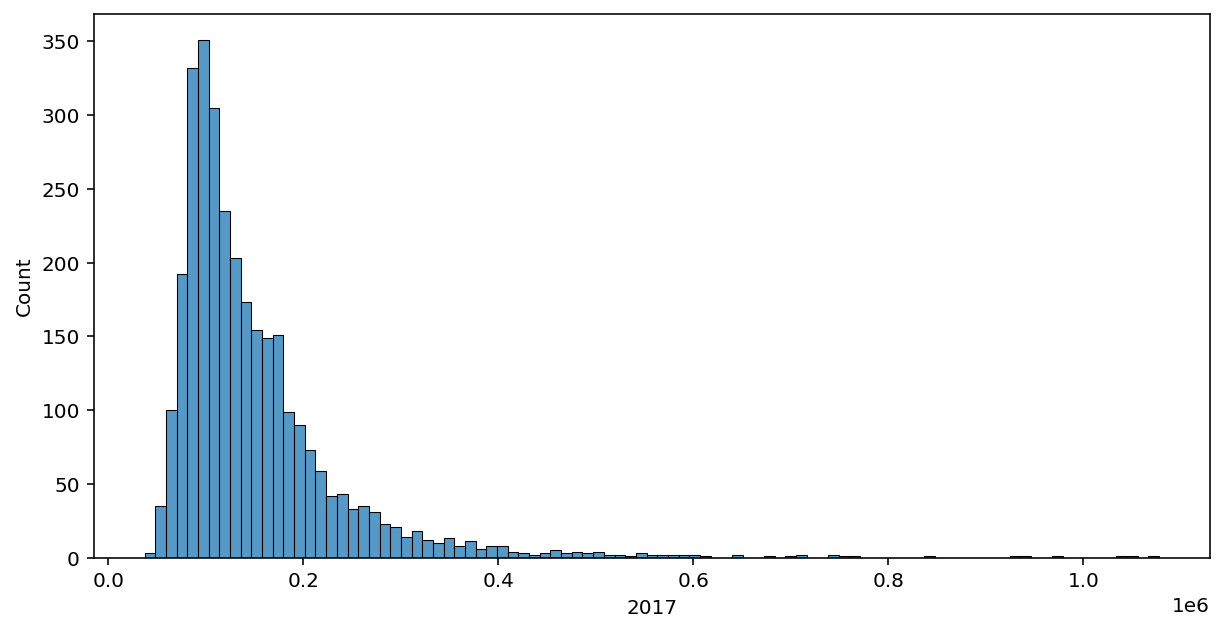

In [833]:
sns.histplot(data = housing_climate_df['2017'])

We see from the histogram that the housing prices for 2017 are skewed very far to the right. Using intuition, we also believe that the housing prices for 2021 will also be skewed very far to the right, so we decide to log transform housing prices.

<AxesSubplot:xlabel='2017 log', ylabel='Count'>

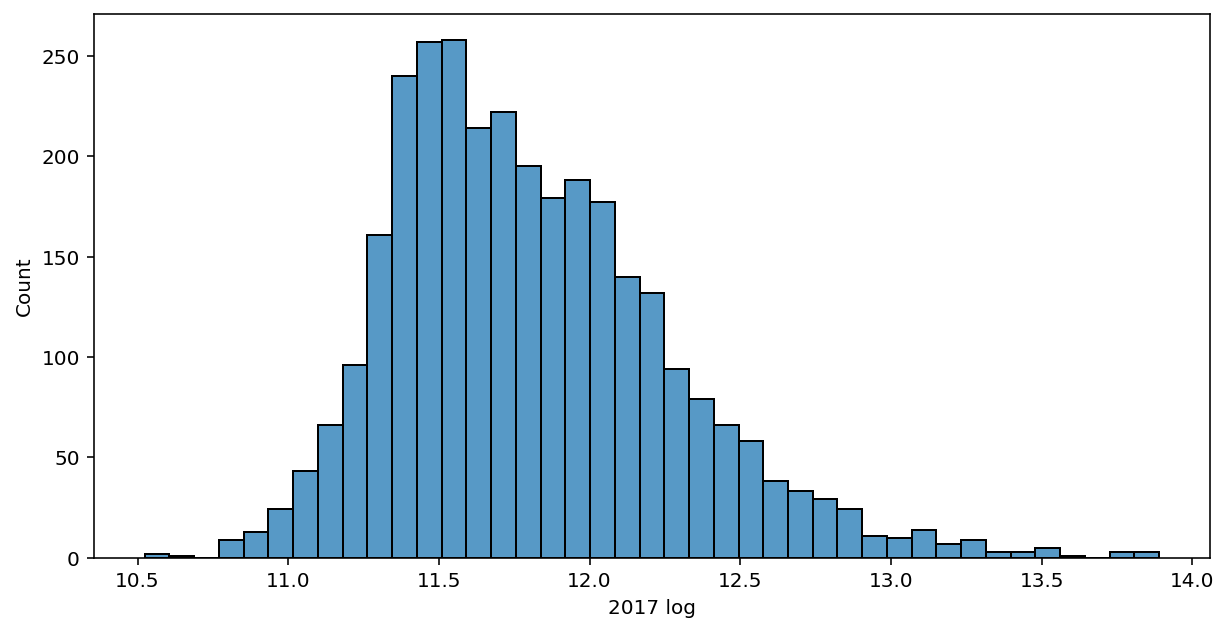

In [834]:
sns.histplot(data = housing_climate_df['2017 log'])

<AxesSubplot:xlabel='2021 log', ylabel='Count'>

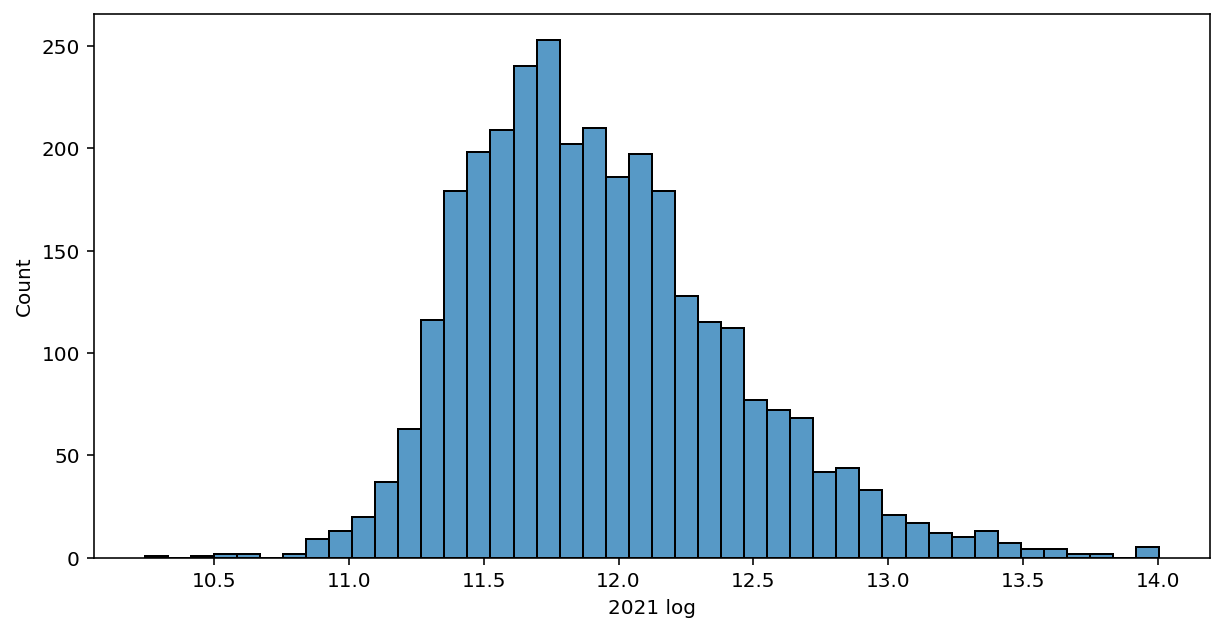

In [835]:
sns.histplot(data = housing_climate_df['2021 log'])

After log transforming the housing prices for 2017 and 2021, we see that our histograms resemble normal distributions much more closely than before.

In [836]:
print("2017 min: $" + str(housing_climate_df['2017 log'].min()))
print("2017 max: $" + str(housing_climate_df['2017 log'].max()))
print("2021 min: $" + str(housing_climate_df['2021 log'].min()))
print("2021 max: $" + str(housing_climate_df['2021 log'].max()))

2017 min: $10.523445569477712
2017 max: $13.89029330240796
2021 min: $10.243845088739151
2021 max: $14.003258200227478


We create a choropleth map for log(2017) and log(2021) to help visualize the housing prices of each county across America. Both maps use the same scale to make them easily comparable. We observe that the East and West coasts of the United States have higher housing prices than the rest of the country.

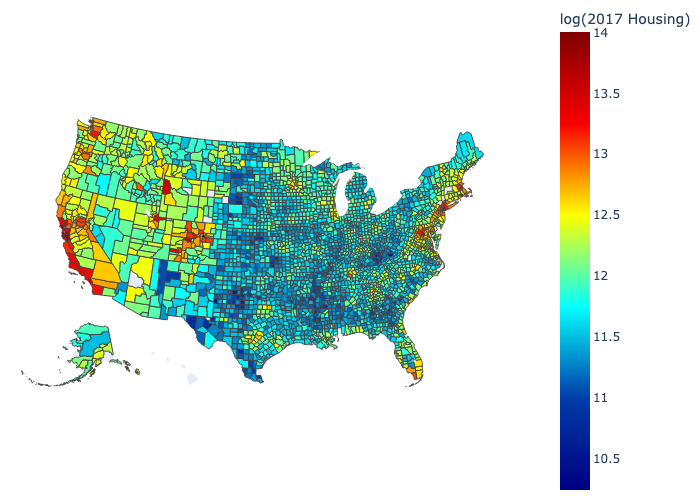

In [837]:
#Choropleth map by county for the log of median 2017 housing prices
fig = px.choropleth(housing_climate_df, geojson=counties, locations='FIPS', color='2017 log',
                           color_continuous_scale="Jet",
                           range_color=(10.24384508873915, 14.003258200227479),
                           scope="usa",
                           labels={'2017 log':'log(2017 Housing)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()
fig.write_image("images/housing_prices_2017.png")
Image(filename='images/housing_prices_2017.png') 


The above graphic is a choropleth map of the log of 2017 Median Housing Prices

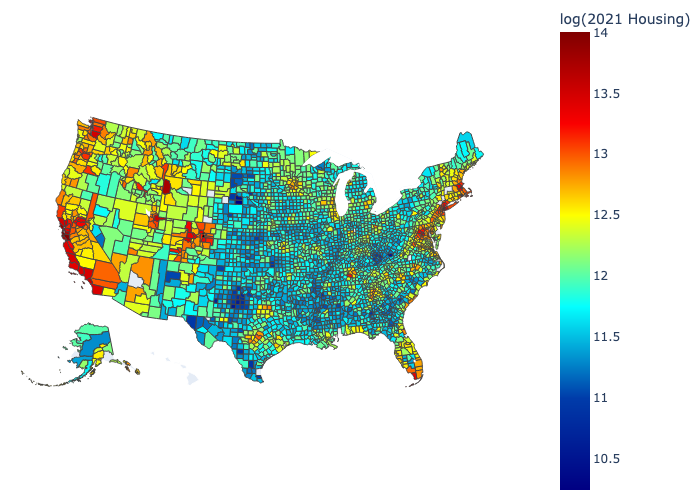

In [838]:
#Choropleth map by county for the log of median 2021 housing prices
#housing_df
fig = px.choropleth(housing_climate_df, geojson=counties, locations='FIPS', color='2021 log',
                           color_continuous_scale="Jet",
                           range_color=(10.24384508873915, 14.003258200227479),
                           scope="usa",
                           labels={'2021 log':'log(2021 Housing)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show() 
fig.write_image("images/housing_prices_2021.png")
Image(filename='images/housing_prices_2021.png') 


The above graphic is a choropleth map of the log of 2021 Median Housing Prices

We create scatterplots for Climate vs log(2017 Housing) as well as Climate vs log(2021 Housing) to visualize the corrrelation between the two variables.

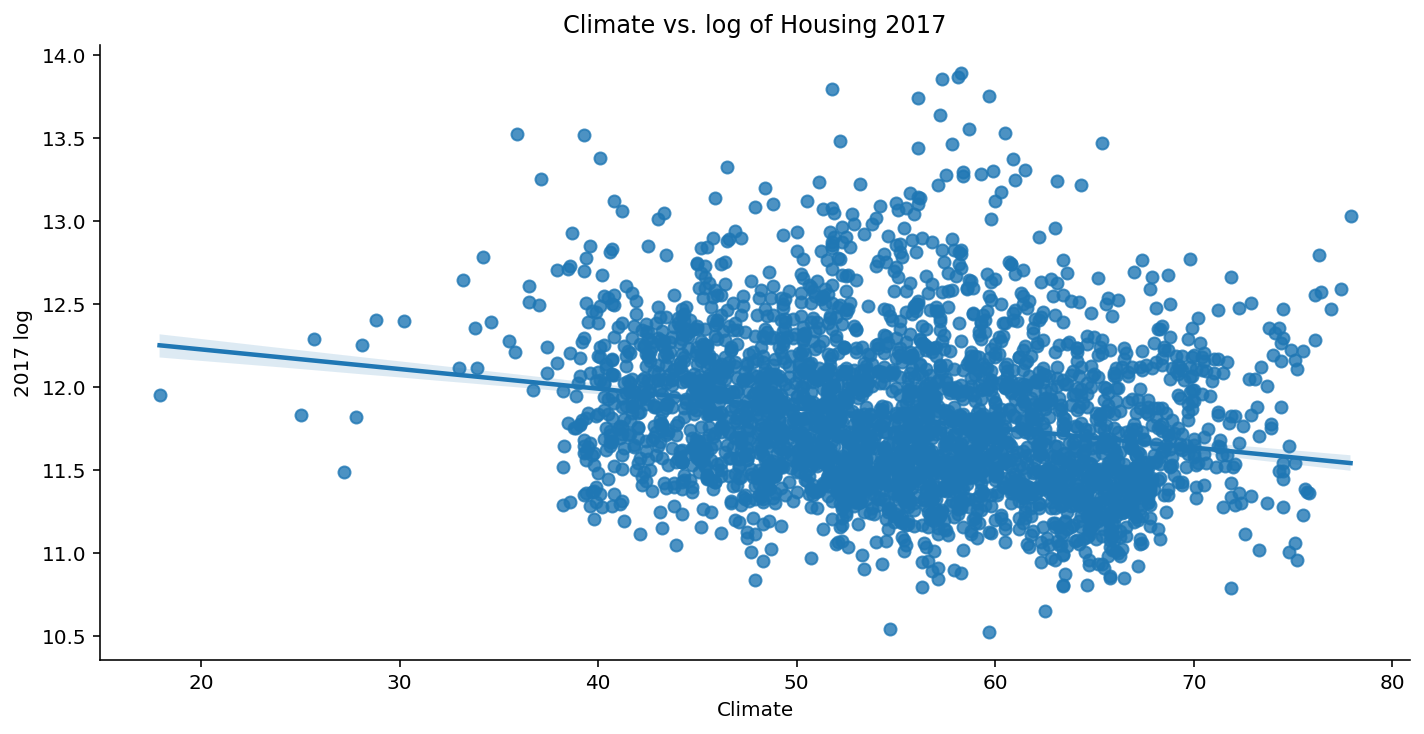

In [839]:
#Scatterplot of Climate and log(2017 housing prices)
sns.lmplot(data = housing_climate_df, x = 'Climate', y = '2017 log', aspect = 2).set(title='Climate vs. log of Housing 2017')

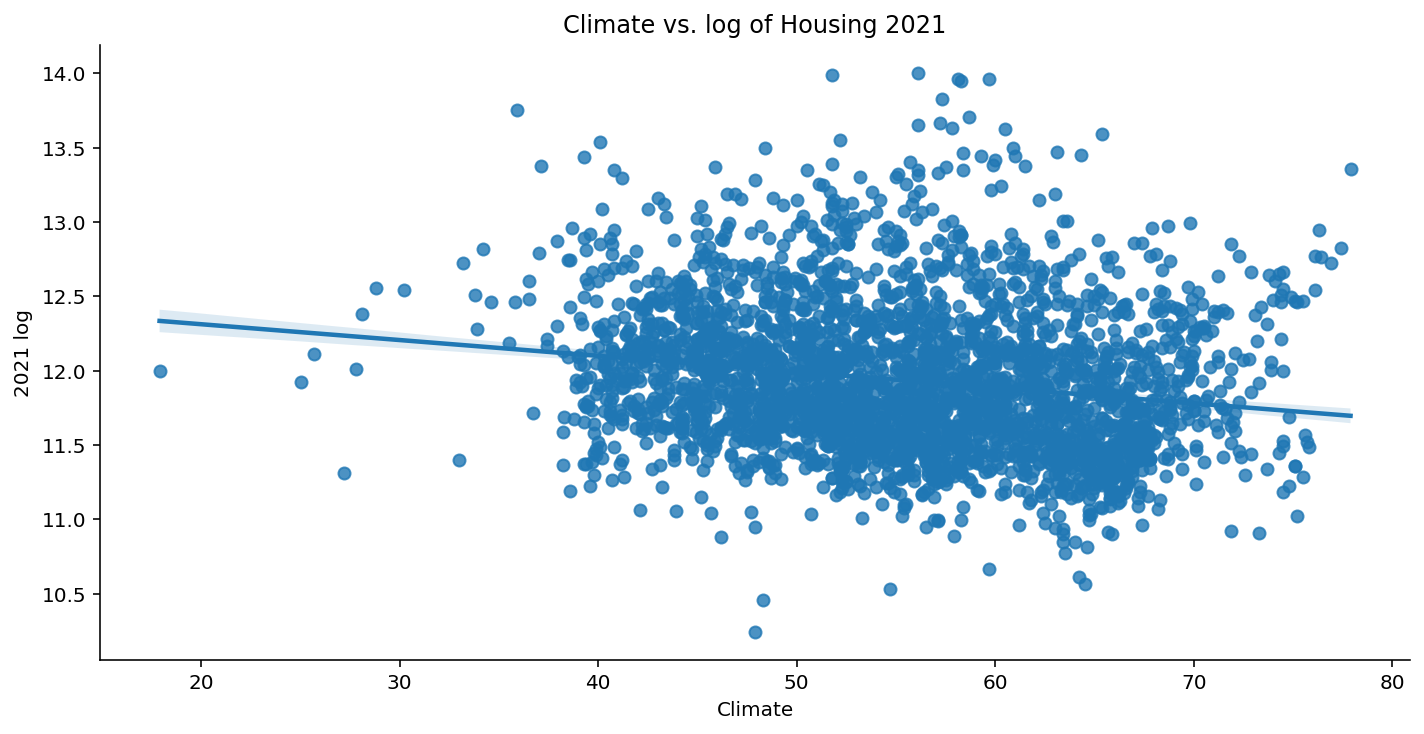

In [840]:
#Scatterplot of Climate and log(2021 housing prices)
sns.lmplot(data = housing_climate_df, x = 'Climate', y = '2021 log', aspect = 2).set(title='Climate vs. log of Housing 2021')

There seems to be a weak negative correlation when using a linear regression model when we compare Climate with the log of housing prices. We find the exact correlation and explain our findings below.

In [841]:
#Calculates correlation between Climate and Housing Prices
housing_climate_df.corr()

2017      2018      2019      2020  \
2017                          1.000000  0.990232  0.987587  0.983964   
2018                          0.990232  1.000000  0.996441  0.992448   
2019                          0.987587  0.996441  1.000000  0.996111   
2020                          0.983964  0.992448  0.996111  1.000000   
2021                          0.982145  0.989747  0.994246  0.999227   
Climate                      -0.152379 -0.129045 -0.128166 -0.125705   
2017 log                      0.919979  0.902406  0.905731  0.909663   
2021 log                      0.893142  0.893049  0.903300  0.915545   
Climate Deviance from Median -0.011035 -0.002910 -0.008748 -0.009904   

                                  2021   Climate  2017 log  2021 log  \
2017                          0.982145 -0.152379  0.919979  0.893142   
2018                          0.989747 -0.129045  0.902406  0.893049   
2019                          0.994246 -0.128166  0.905731  0.903300   
2020                          0.999227 -0.125705  0.909663  0.915545   
2021                          1.000000 -0.127605  0.912524  0.919940   
Climate                      -0.127605  1.000000 -0.217924 -0.185025   
2017 log                      0.912524 -0.217924  1.000000  0.976306   
2021 log                      0.919940 -0.185025  0.976306  1.000000   
Climate Deviance from Median -0.012609  0.034533 -0.044470 -0.039267   

                              Climate Deviance from Median  
2017                                             -0.011035  
2018                                             -0.002910  
2019                                             -0.008748  
2020                                             -0.009904  
2021                                             -0.012609  
Climate                                           0.034533  
2017 log                                         -0.044470  
2021 log                                         -0.039267  
Climate Deviance from Median                      1.000000

As we can see, the correlation between Climate and log(2017) is r = -0.217924, and the correlation between Climate and log(2021) is r = -0.185025. Both correlations are weak and negative. This implies that counties with warmer climates tend to have lower housing prices than counties with colder climates.

This is surprising to us because from the choropleth map of Climate we see that states that have high housing prices such as California and Florida tend to have warmer climates. We turn to analyzing the deviation from median of each counties climates because areas with more moderate climates should have higher housing prices than areas with more extreme climates. 

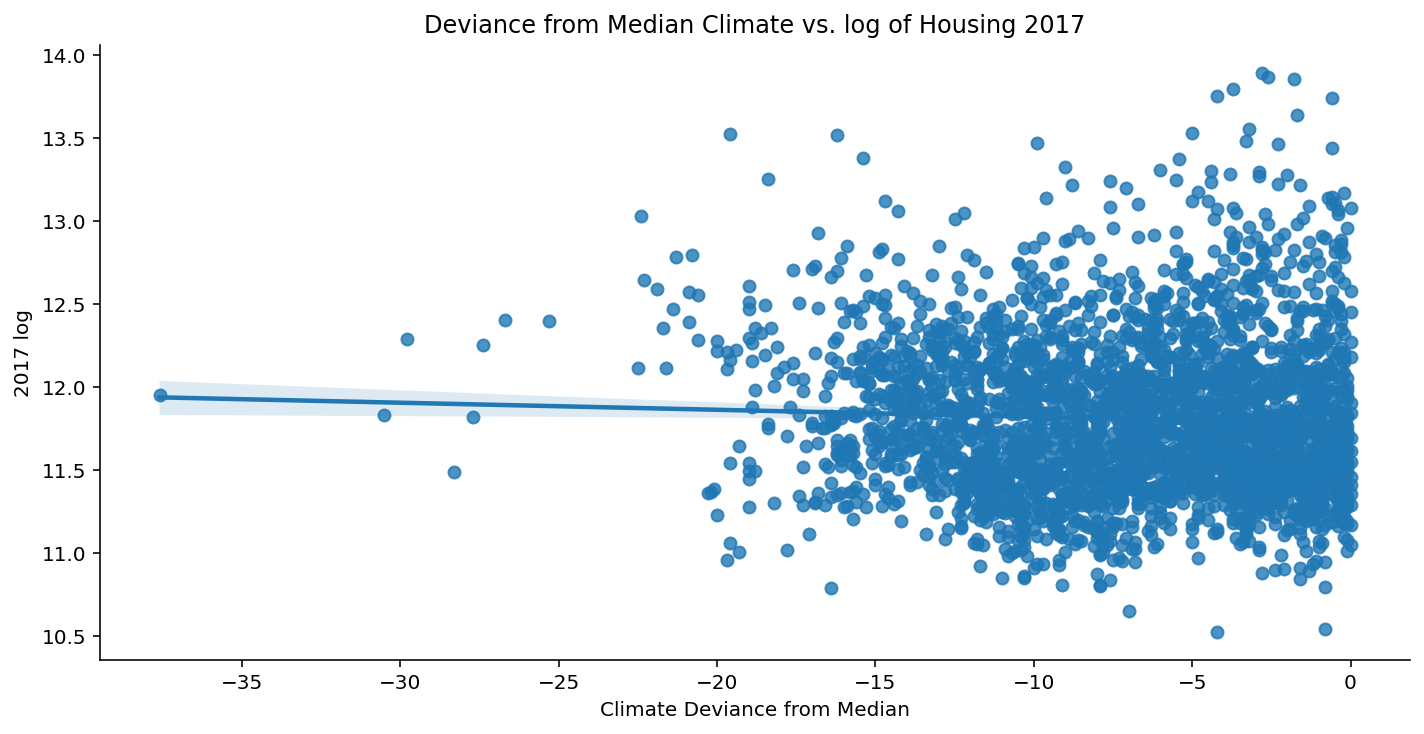

In [842]:
#Scatterplot of Climate and log(2021 housing prices)
sns.lmplot(data = housing_climate_df, x = 'Climate Deviance from Median', y = '2017 log', aspect = 2).set(title='Deviance from Median Climate vs. log of Housing 2017')

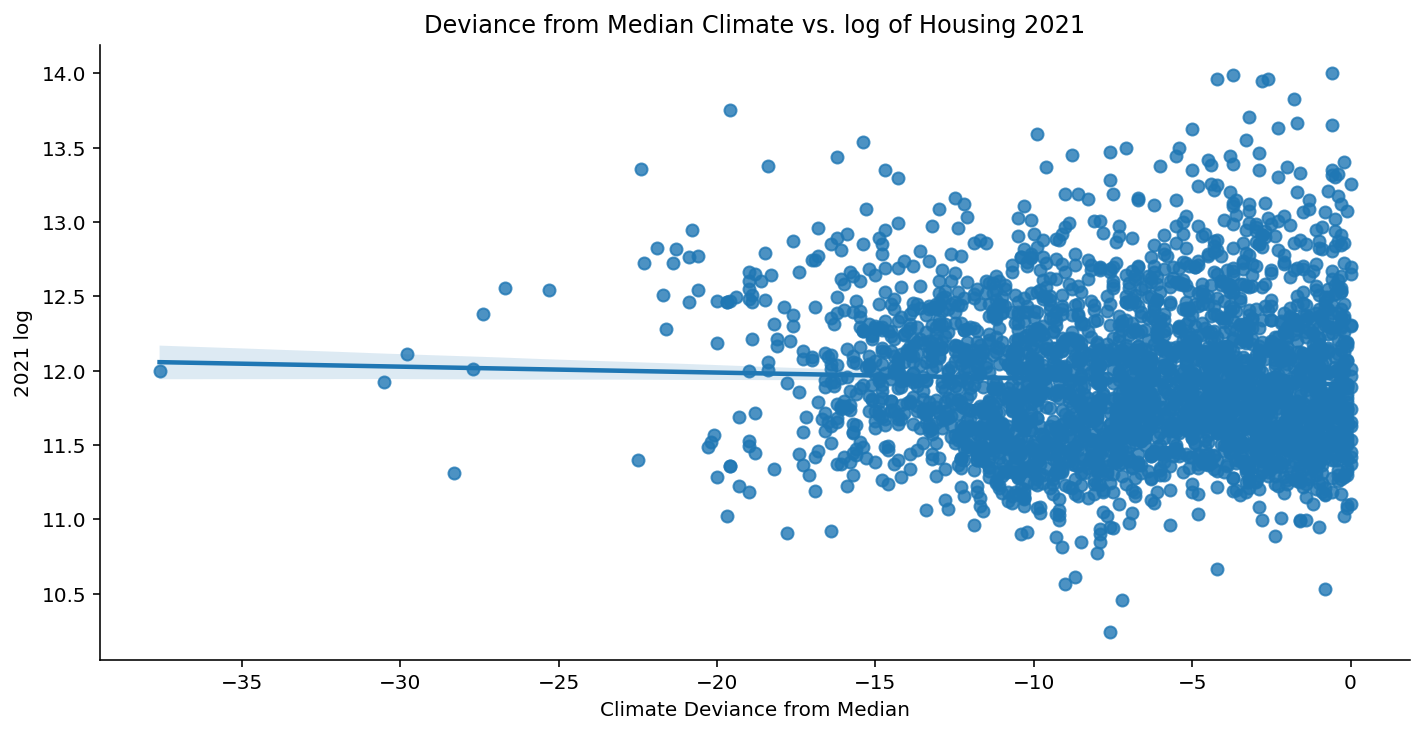

In [843]:
#Scatterplot of Climate and log(2021 housing prices)
sns.lmplot(data = housing_climate_df, x = 'Climate Deviance from Median', y = '2021 log', aspect = 2).set(title='Deviance from Median Climate vs. log of Housing 2021')

We see that the correlation between Deviance from Median Climate and log(2017) and the correlation between Deviance from Median Climate and log(2021) are both around 0. We also observe that most of the datapoints are on the right of the scatterplot, which makes sense because a deviance closer to 0 means a climate closer to the median climate of all counties. We calculate the exact correlations and explain our findings below.

In [844]:
#Calculates correlation between Climate and Housing Prices
housing_climate_df.corr()

2017      2018      2019      2020  \
2017                          1.000000  0.990232  0.987587  0.983964   
2018                          0.990232  1.000000  0.996441  0.992448   
2019                          0.987587  0.996441  1.000000  0.996111   
2020                          0.983964  0.992448  0.996111  1.000000   
2021                          0.982145  0.989747  0.994246  0.999227   
Climate                      -0.152379 -0.129045 -0.128166 -0.125705   
2017 log                      0.919979  0.902406  0.905731  0.909663   
2021 log                      0.893142  0.893049  0.903300  0.915545   
Climate Deviance from Median -0.011035 -0.002910 -0.008748 -0.009904   

                                  2021   Climate  2017 log  2021 log  \
2017                          0.982145 -0.152379  0.919979  0.893142   
2018                          0.989747 -0.129045  0.902406  0.893049   
2019                          0.994246 -0.128166  0.905731  0.903300   
2020                          0.999227 -0.125705  0.909663  0.915545   
2021                          1.000000 -0.127605  0.912524  0.919940   
Climate                      -0.127605  1.000000 -0.217924 -0.185025   
2017 log                      0.912524 -0.217924  1.000000  0.976306   
2021 log                      0.919940 -0.185025  0.976306  1.000000   
Climate Deviance from Median -0.012609  0.034533 -0.044470 -0.039267   

                              Climate Deviance from Median  
2017                                             -0.011035  
2018                                             -0.002910  
2019                                             -0.008748  
2020                                             -0.009904  
2021                                             -0.012609  
Climate                                           0.034533  
2017 log                                         -0.044470  
2021 log                                         -0.039267  
Climate Deviance from Median                      1.000000

As we can see, the correlation between the Deviance from Median Climate and log(2017) is r = -0.044470, and the correlation between the Deviance from Median Climate and log(2021) is r = -0.039267. Both correlations are extremely weak and negative. This is surprising because this means there is a very weak negative correlation between how moderate a counties climate is and the counties median housing price. 

## EDA for Personal Income per Capita

<AxesSubplot:xlabel='2017', ylabel='Count'>

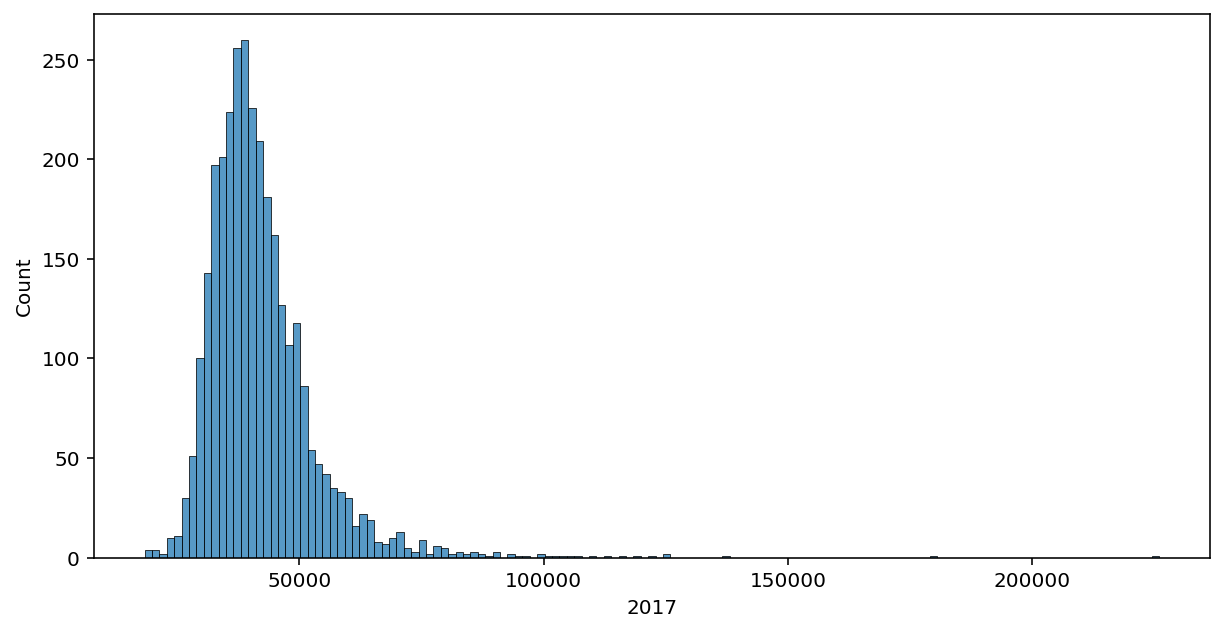

In [845]:
sns.histplot(data=income_df['2017'])

<AxesSubplot:xlabel='2017 log', ylabel='Count'>

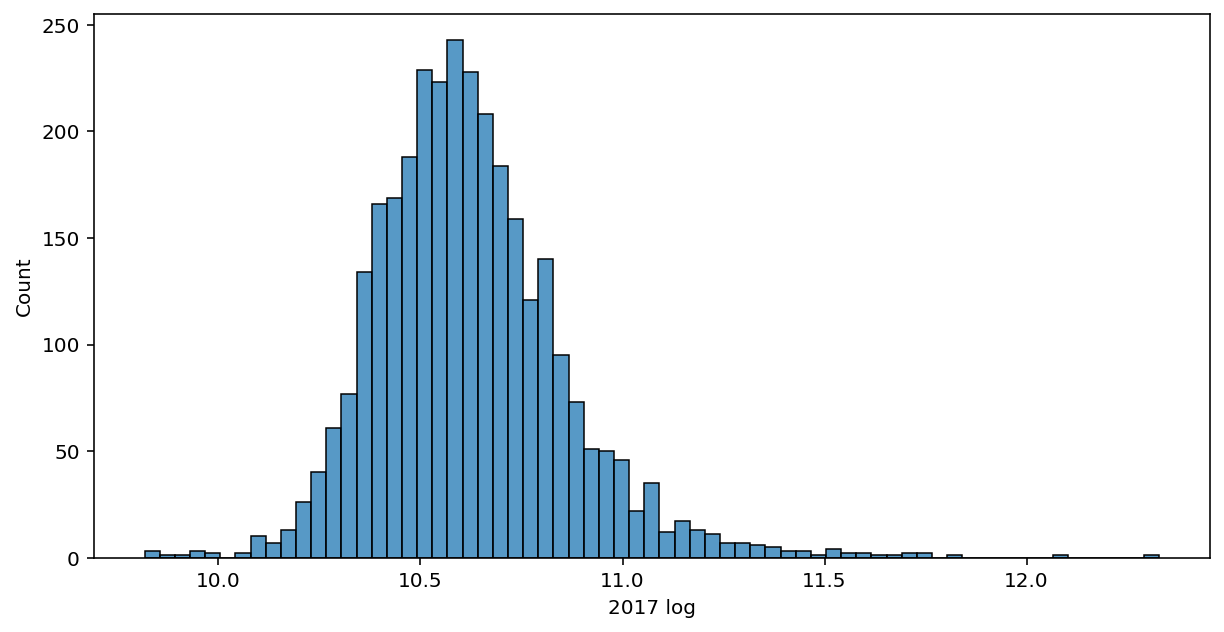

In [846]:
sns.histplot(data = income_df['2017 log'])

<AxesSubplot:xlabel='2020 log', ylabel='Count'>

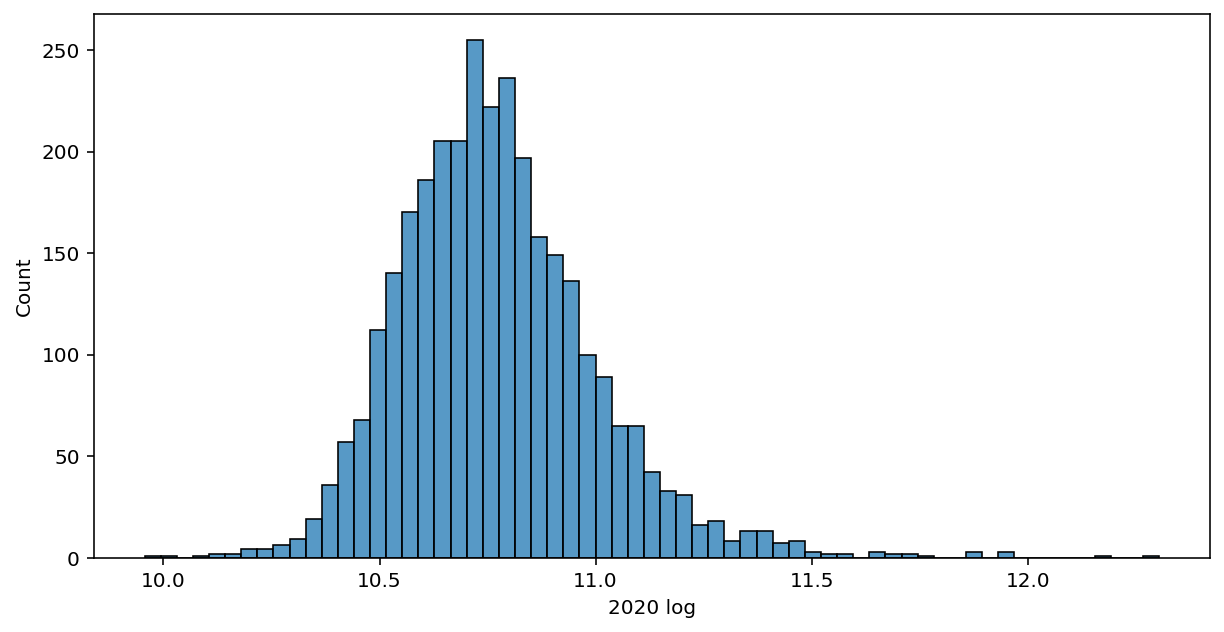

In [847]:
sns.histplot(data = income_df['2020 log'])

In [848]:
print(income_df['2017 log'].min())
print(income_df['2017 log'].max())
print(income_df['2020 log'].min())
print(income_df['2020 log'].max())

9.81722135237872
12.328232754476069
9.956412015844014
12.304310354119167


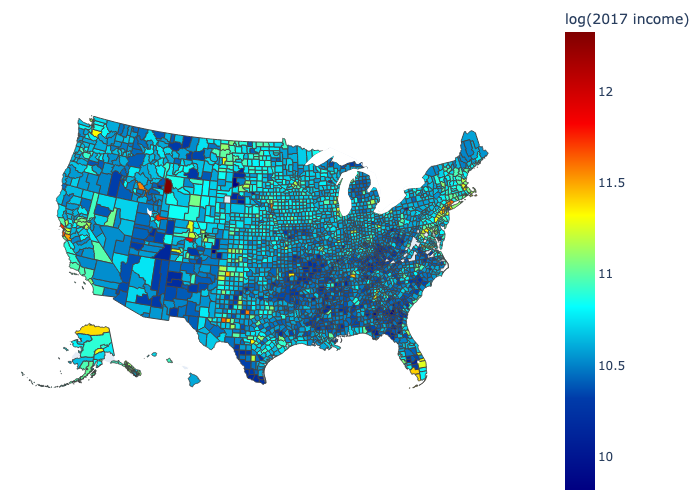

In [849]:
#Choropleth map by county for the log of personal income in 2017
fig = px.choropleth(income_df, geojson=counties, locations='FIPS', color='2017 log',
                           color_continuous_scale="Jet",
                           range_color=(9.8172213523787, 12.32823275447607),
                           scope="usa",
                           labels={'2017 log':'log(2017 income)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()
fig.write_image("images/personal_income_2017.png")
Image(filename='images/personal_income_2017.png') 

In [850]:
#Choropleth map by county for the log of personal income in 2020
fig = px.choropleth(income_df, geojson=counties, locations='FIPS', color='2020 log',
                           color_continuous_scale="Jet",
                           range_color=(9.8172213523787, 12.32823275447607),
                           scope="usa",
                           labels={'2020 log':'log(2020 income)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()
fig.write_image("images/personal_income_2020.png")
Image(filename='images/personal_income_2020.png') 

## EDA for Personal Income per Capita vs Median Housing Prices

In [851]:
income_housing_df.head()

County & State   FIPS    2017    2018    2019    2020  \
0  Autauga County,  Alabama  01001  145203  144361  153716  160972   
1  Baldwin County,  Alabama  01003  185313  205764  209494  232730   
2  Barbour County,  Alabama  01005   97533   91965  100423   94615   
3     Bibb County,  Alabama  01007  116052  110683  101799   97807   
4   Blount County,  Alabama  01009  135375  128203  131548  134696   

   2017 income log  2020 income log  2017 housing log  2020 housing log  
0        10.636552        10.753938         11.885888         11.988986  
1        10.723201        10.838659         12.129802         12.357634  
2        10.396933        10.541386         11.487946         11.457571  
3        10.277118        10.442901         11.661794         11.490751  
4        10.446393        10.566382         11.815804         11.810776

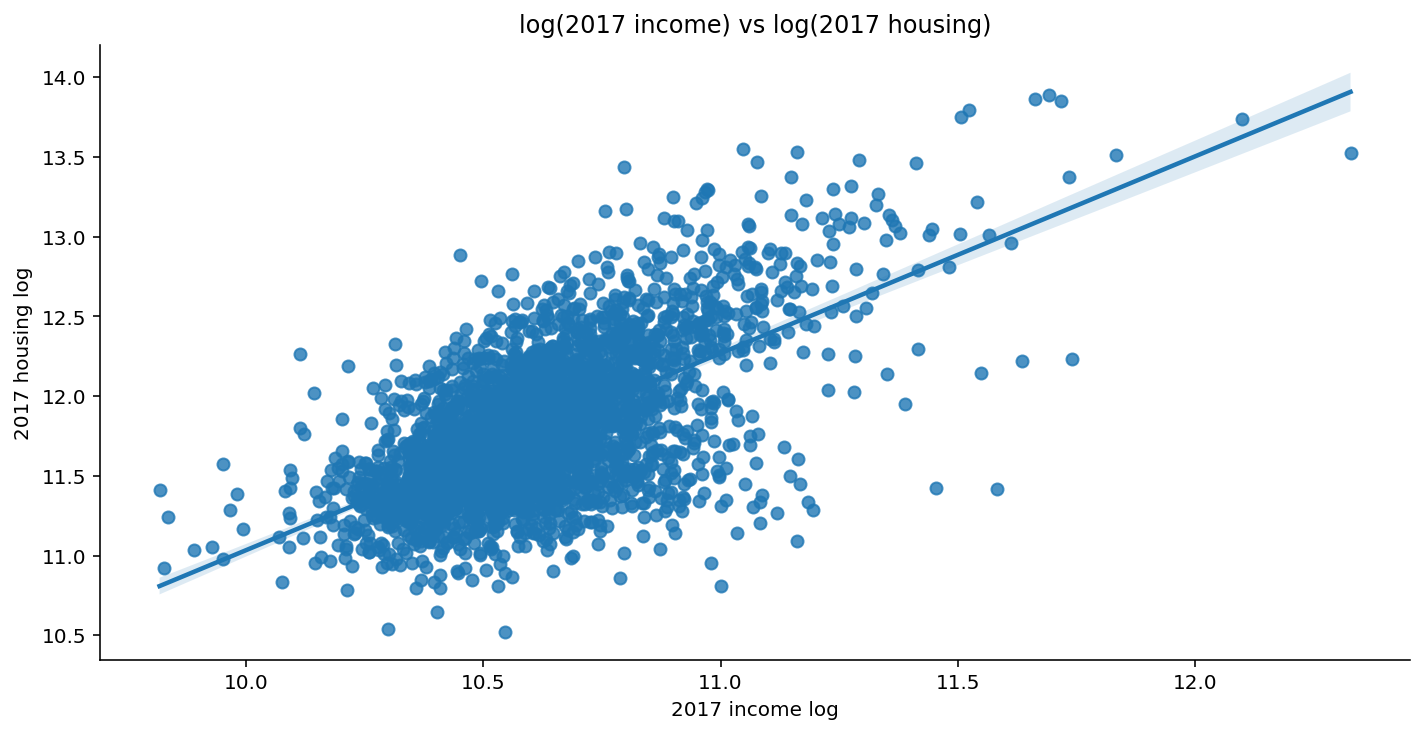

In [852]:
sns.lmplot(data = income_housing_df, x = '2017 income log', y = '2017 housing log', aspect = 2).set(title = 'log(2017 income) vs log(2017 housing)')

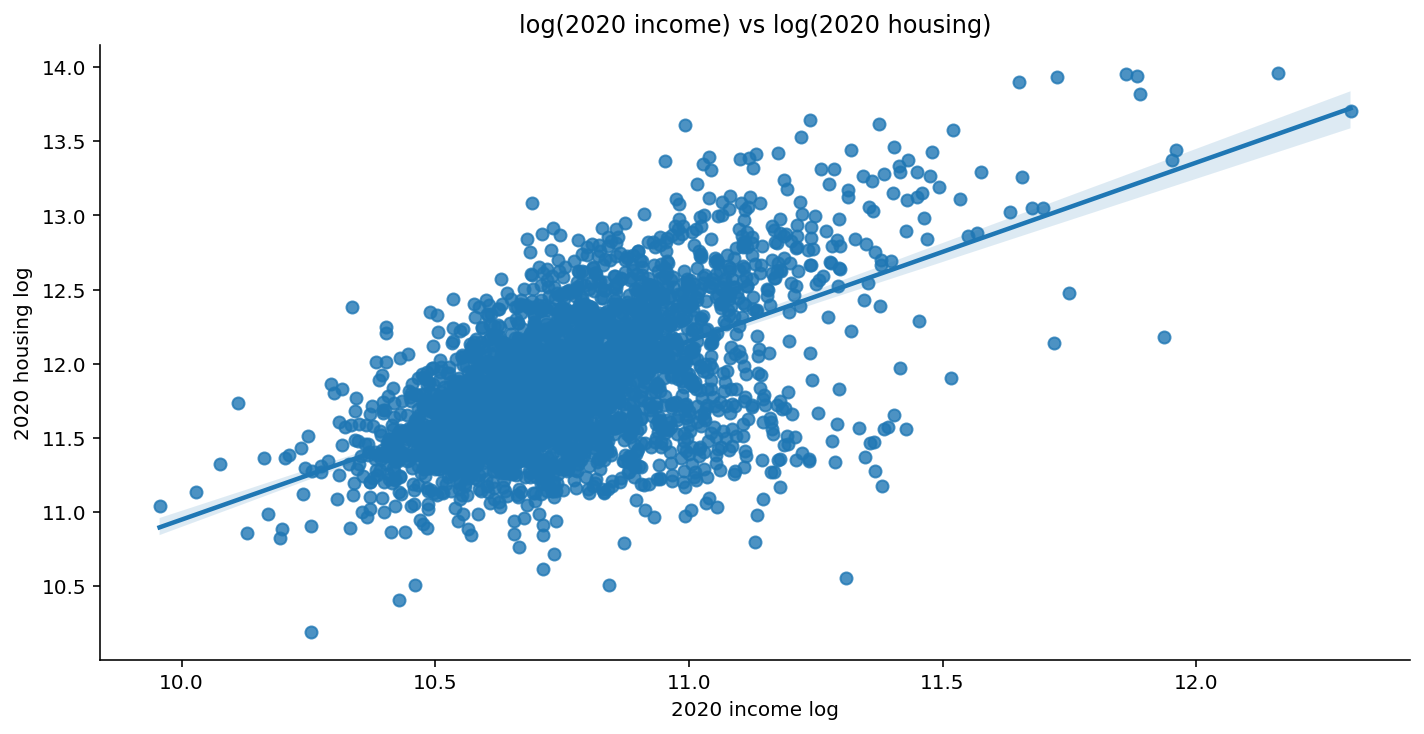

In [853]:
sns.lmplot(data = income_housing_df, x = '2020 income log', y = '2020 housing log', aspect = 2).set(title = 'log(2020 income) vs log(2020 housing)')

In [854]:
income_housing_df.corr()

2017      2018      2019      2020  2017 income log  \
2017              1.000000  0.990420  0.987724  0.984141         0.630877   
2018              0.990420  1.000000  0.996456  0.992473         0.627526   
2019              0.987724  0.996456  1.000000  0.996106         0.628562   
2020              0.984141  0.992473  0.996106  1.000000         0.624050   
2017 income log   0.630877  0.627526  0.628562  0.624050         1.000000   
2020 income log   0.603767  0.599520  0.600463  0.595972         0.967556   
2017 housing log  0.919693  0.900829  0.904290  0.908529         0.623776   
2020 housing log  0.895178  0.894701  0.904989  0.917025         0.612016   

                  2020 income log  2017 housing log  2020 housing log  
2017                     0.603767          0.919693          0.895178  
2018                     0.599520          0.900829          0.894701  
2019                     0.600463          0.904290          0.904989  
2020                     0.595972          0.908529          0.917025  
2017 income log          0.967556          0.623776          0.612016  
2020 income log          1.000000          0.581569          0.568464  
2017 housing log         0.581569          1.000000          0.976214  
2020 housing log         0.568464          0.976214          1.000000

## EDA and Analysis for Predicting 2021 Housing Price using Various Components of NRI Risk Index Score

In [855]:
df_housing_nri_merged.columns

Index(['County & State', 'FIPS', '2017', '2018', '2019', '2020', '2021',
       'state', 'state_abbrv', 'state_fips', 'county', 'county_fips',
       'population', 'area', 'risk_score', 'risk_rating', 'eal_score',
       'eal_rating', 'sovi_score', 'resl_score', 'risk_encoded', 'eal_encoded',
       '2021_boxcox', 'risk_score_log10', 'eal_score_log10', '2017_boxcox',
       '2018_boxcox', '2019_boxcox', '2020_boxcox'],
      dtype='object')

Next, we are interested in seeing what component of the NRI Risk Index Score (social vulnerability and expected annual loss) has the biggest effect on predicting 2021 housing price. Before conducting the analysis, some EDA was carried out for the social vulnerability score variabe. Note that EDA for housing price and expected annual loss was carried out earlier so we only needed to do EDA on the social vulnerability score variable. We created a boxplot of the social vulnerability score to visualize the distribution. Upon looking at the result, there appears to be several outliers that contain lower and highervalues of the social vulnerability score. To identify the outliers, the first quartile, third quartile, and interquartile range were computed. 

(array([-20.,   0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

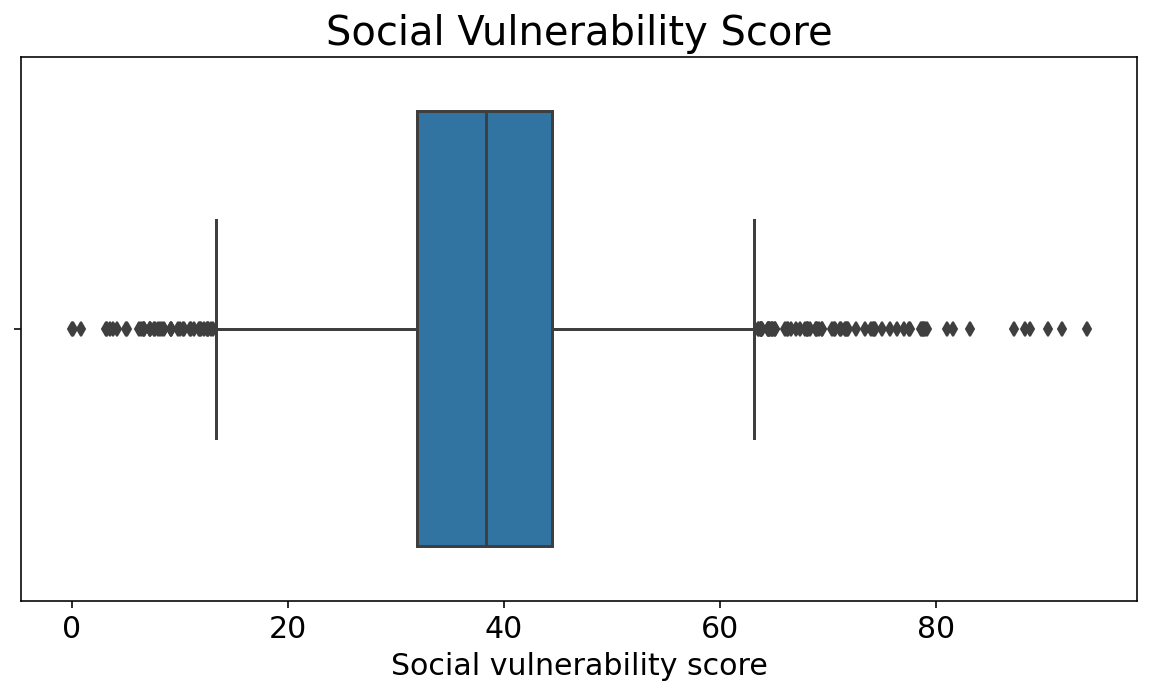

In [856]:
sovi_boxplot = sns.boxplot(x= 'sovi_score', data= df_housing_nri_merged)
sovi_boxplot.set_title('Social Vulnerability Score', fontsize= 20)
sovi_boxplot.set_xlabel('Social vulnerability score', fontsize= 15)
plt.xticks(fontsize=15)

In [857]:
q1_sovi = np.quantile(df_housing_nri_merged['sovi_score'], 0.25)
q1_sovi

31.92747339377217

In [858]:
q3_sovi = np.quantile(df_housing_nri_merged['sovi_score'], 0.75)
q3_sovi

44.46196294836422

In [859]:
iqr_sovi = q3_sovi - q1_sovi
iqr_sovi

12.534489554592046

In [860]:
whisker1 = q1_sovi - (1.5* iqr_sovi)
whisker1

13.1257390618841

In [861]:
whisker2 = q3_sovi + (1.5* iqr_sovi)
whisker2

63.26369728025229

In [862]:
# identify outliers
df_housing_nri_merged[(df_housing_nri_merged['sovi_score'] <= whisker1) |
                     (df_housing_nri_merged['sovi_score'] >= whisker2)]

County & State   FIPS      2017      2018  \
52                 Perry County,  Alabama  01105   70135.0   71162.0   
70            Bethel Census Area,  Alaska  02050  182029.0  158099.0   
73        Dillingham Census Area,  Alaska  02070  214325.0  196328.0   
80    Lake and Peninsula Borough,  Alaska  02164  159288.0  122770.0   
82              Nome Census Area,  Alaska  02180  135670.0  148153.0   
...                                   ...    ...       ...       ...   
2905             Sussex County,  Virginia  51183  161203.0  128927.0   
2908           Petersburg city,  Virginia  51730  128480.0  119703.0   
3051         Menominee County,  Wisconsin  55078   90967.0   89691.0   
3097            Campbell County,  Wyoming  56005  229782.0  222673.0   
3110            Sublette County,  Wyoming  56035  298435.0  275661.0   

          2019      2020      2021      state state_abbrv  state_fips  ...  \
52     71236.0   67806.0   70985.0    Alabama          AL           1  ...   
70    117976.0   86445.0   89174.0     Alaska          AK           2  ...   
73    196127.0  189745.0  195735.0     Alaska          AK           2  ...   
80    128681.0  118810.0  122561.0     Alaska          AK           2  ...   
82    160156.0  159861.0  164908.0     Alaska          AK           2  ...   
...        ...       ...       ...        ...         ...         ...  ...   
2905  132148.0  131776.0  139437.0   Virginia          VA          51  ...   
2908  113210.0  113235.0  119818.0   Virginia          VA          51  ...   
3051  108629.0  105913.0  111368.0  Wisconsin          WI          55  ...   
3097  230980.0  229815.0  241224.0    Wyoming          WY          56  ...   
3110  285946.0  283889.0  297982.0    Wyoming          WY          56  ...   

     resl_score  risk_encoded  eal_encoded  2021_boxcox  risk_score_log10  \
52    49.611202             2            1     2.192279          1.013779   
70    49.889798             2            1     2.193650          0.976171   
73    48.379798             1            1     2.197423          0.775963   
80    46.804800             2            1     2.195339          0.972709   
82    48.764600             2            1     2.196711          0.926451   
...         ...           ...          ...          ...               ...   
2905  52.139802             1            1     2.195958          0.152657   
2908  57.457200             2            1     2.195227          0.988400   
3051  55.710202             1            1     2.194856          0.836954   
3097  51.189800             1            2     2.198219          0.322908   
3110  47.528800             1            2     2.198952          0.410838   

     eal_score_log10  2017_boxcox 2018_boxcox  2019_boxcox  2020_boxcox  
52          0.843981     1.756078    1.904462     1.949517     2.183499  
70          0.706742     1.757373    1.906341     1.950986     2.184954  
73          0.533712     1.757532    1.906729     1.952129     2.188700  
80          0.630202     1.757231    1.905828     1.951203     2.186632  
82          0.658719     1.757046    1.906216     1.951708     2.187993  
...              ...          ...         ...          ...          ...  
2905        0.709330     1.757244    1.905933     1.951267     2.187128  
2908        0.857905     1.756979    1.905773     1.950879     2.186394  
3051        0.584827     1.756503    1.905089     1.950771     2.186054  
3097        1.094210     1.757596    1.906936     1.952437     2.189427  
3110        1.089865     1.757814    1.907256     1.952804     2.190158  

[113 rows x 29 columns]

Let's look at the correlations between 2021 housing price with expected annual loss and social vulnerability score.

In [863]:
# make a new dataframe with the relevant variables
df_housing_nri_merged_new = df_housing_nri_merged[['2021_boxcox', 'eal_score_log10', 'sovi_score']]
df_housing_nri_merged_new

2021_boxcox  eal_score_log10  sovi_score
0        2.196748         1.032930   25.857312
1        2.198255         1.274967   34.292471
2        2.194235         1.080463   34.686638
3        2.194411         0.962656   21.482065
4        2.196007         1.165789   29.720142
...           ...              ...         ...
3112     2.201906         1.179102   19.511234
3113     2.197294         0.931355   24.044147
3114     2.197072         0.755309   41.308632
3115     2.197085         0.807446   26.724478
3116     2.198933         1.270235   29.207726

[3117 rows x 3 columns]

Text(0.5, 1.0, 'Heatmap for 2021 Housing Price, Expected Annual Loss score, and Social Vulnerability Score')

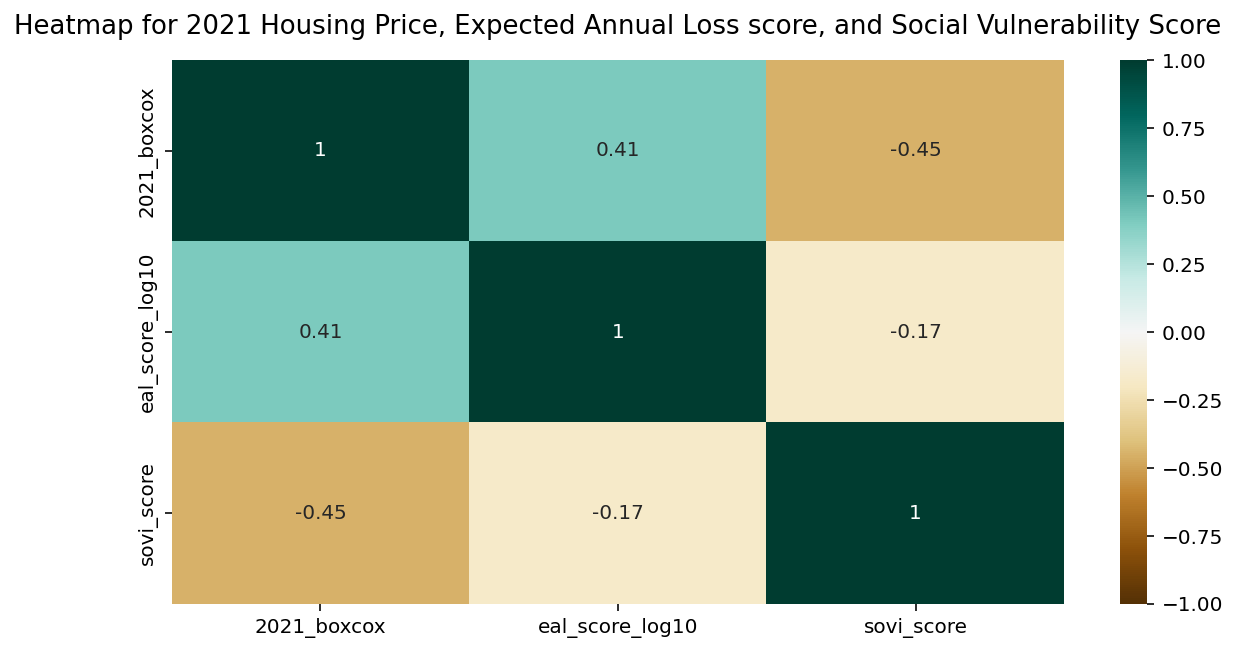

In [864]:
df_housing_heatmap = sns.heatmap(df_housing_nri_merged_new.corr(), vmin= -1, vmax= 1, annot= True,
                                cmap='BrBG')
df_housing_heatmap.set_title('Heatmap for 2021 Housing Price, Expected Annual Loss score, and Social Vulnerability Score', 
                             fontdict={'fontsize':13}, pad=13)

Text(0.5, 1.0, 'Correlations with 2021 Housing Price')

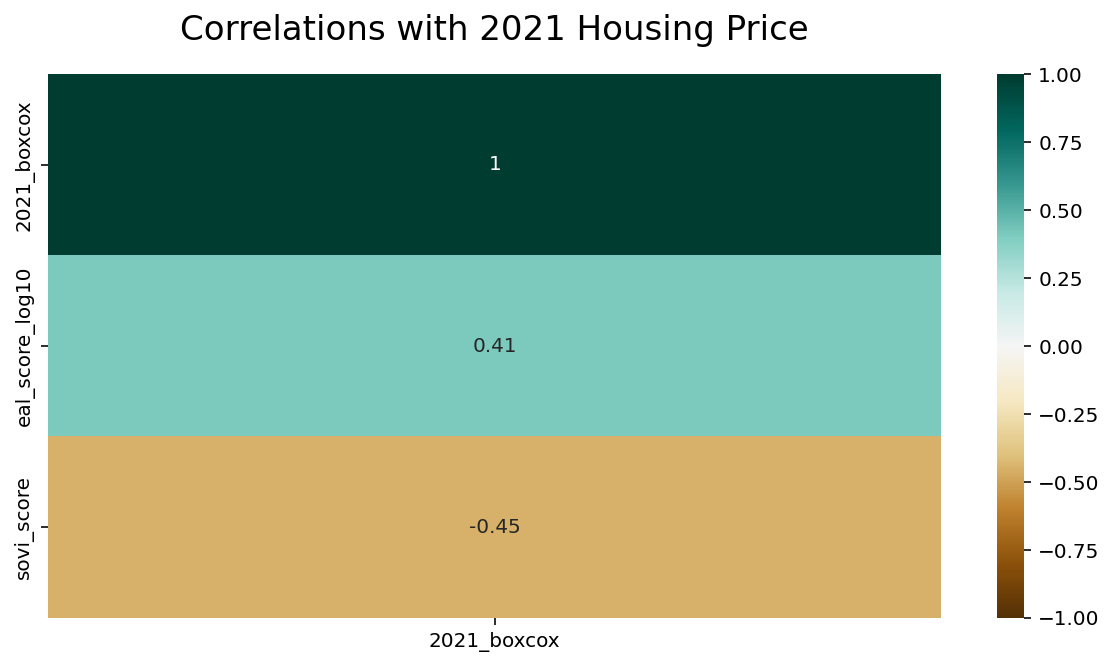

In [865]:
# look at the relevant correlations
housing_heatmap = sns.heatmap(df_housing_nri_merged_new.corr()[['2021_boxcox']].sort_values(by='2021_boxcox', 
                                        ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
housing_heatmap.set_title('Correlations with 2021 Housing Price', fontdict={'fontsize':17}, pad=17)

Since we want to model the relationship between a continuous dependent variable (2021 housing price) using multiple continuous predictors (social vulnerability and expected annual loss), a linear regression was used. Note that we did not include the community resilience component of the NRI Risk Index Score in the linear regression because this variable is highly correlated with social vulnerability and expected annual loss, which posed an issue of multicollinearity. Before carrying out a linear regression, we first need to check that the assumptions hold for linear regression:

1) Linear relationship, 2) Multivariate normality, 3) No multicollinearity, 4) Homoscedasticity

2) Multivariate normality: We first checked for multivariate normality by looking at the histogram of the social vulnerability variable ("sovi_score"). The histogram looks approximately normal, so there is no transformation needed on this variable. The distributions of expected annual loss variable and 2021 housing prices were looked at in an earlier cell above and were transformed. Thus, the new transformed variables were used in the linear regression. With all the necessary variables transformed, the assumption of multivariate normality is verified.

(array([  0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

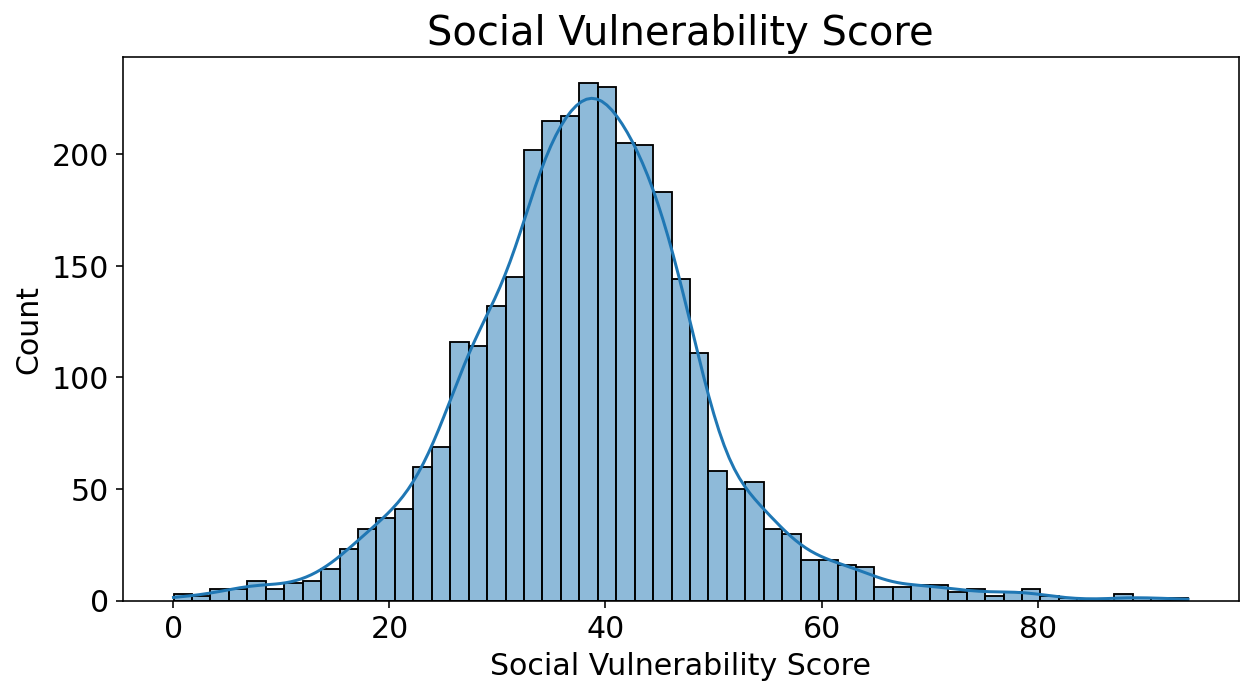

In [866]:
sovi_hist = sns.histplot(df_housing_nri_merged['sovi_score'], kde= True)
sovi_hist.set_title('Social Vulnerability Score', fontsize= 20)
sovi_hist.set_xlabel('Social Vulnerability Score', fontsize= 15)
sovi_hist.set_ylabel('Count', fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

1) Linear relationship: We then checked for a linear relationship between the 2021 housing price with expected annual loss and 2021 housing price and the social vulnerability score by creating scatter plots. As seen by the first column in the scatter matrix, there appears to be a linear relationship between 2021 housing price with expected annual loss and 2021 housing price and the social vulnerability score. Thus, the linear relationship assumption is verified.

3) No multicollinearity: From these scatterplots we can also check if there is multicollinearity between the independent variables (which are "eal_score_log10" and "sovi_score"). From the scatterplot of eal_score_log_10 vs. sovi_score, we see visually that there is a weak, negative correlation between the two. This was confirmed by computing the actual correlation value in the cell following. Thus, multicollinearity does not appear to be an issue here. 

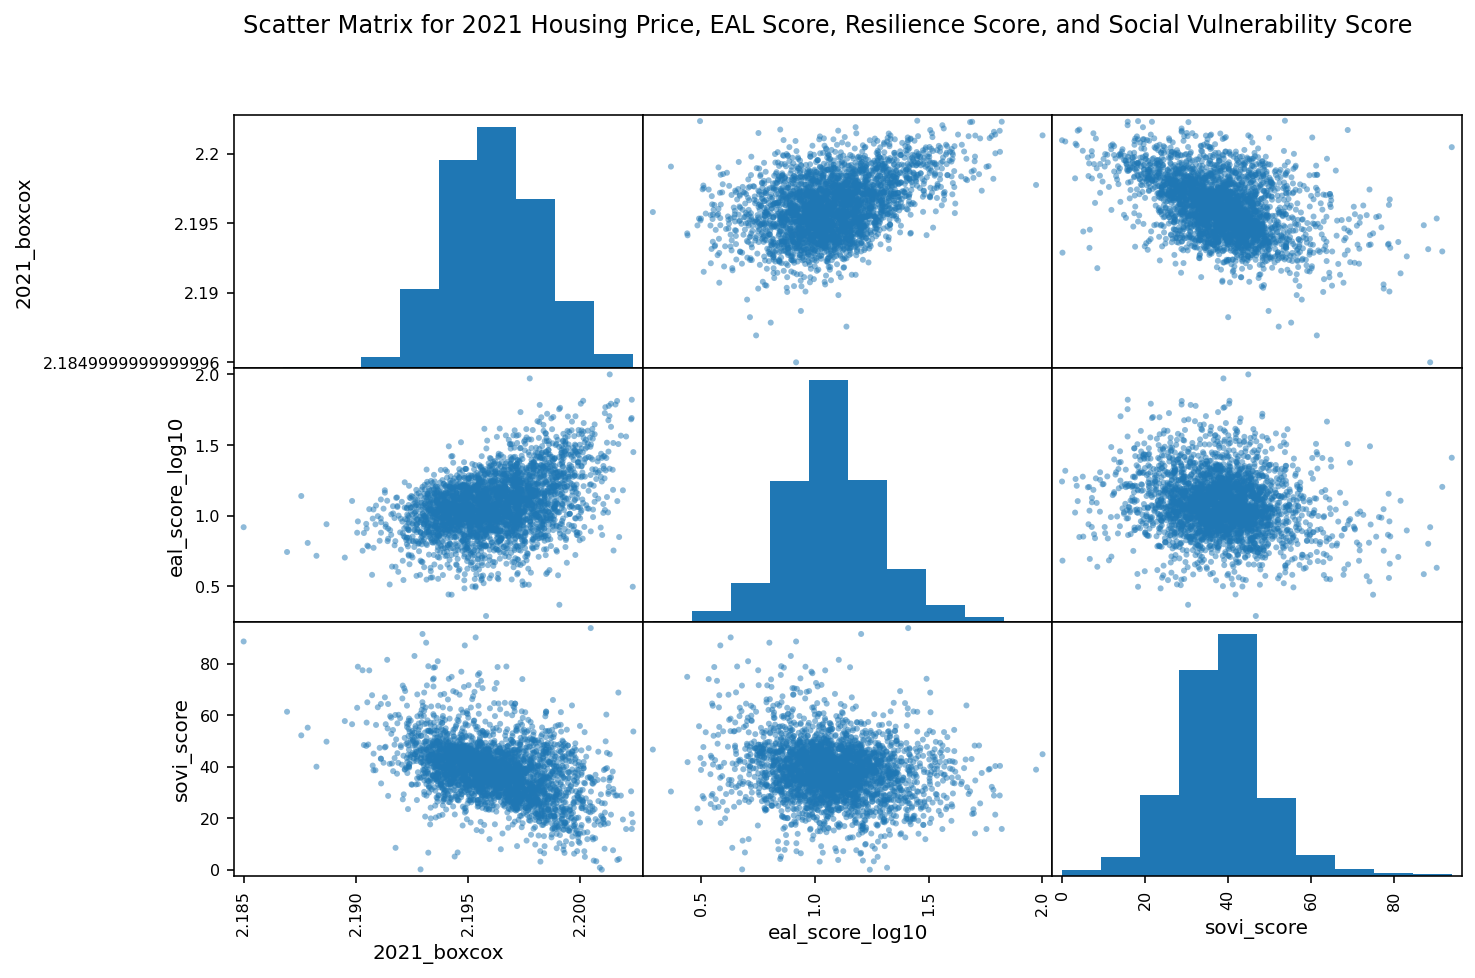

In [867]:
# check for linear relationship and multicollinearity
pd.plotting.scatter_matrix(df_housing_nri_merged[['2021_boxcox', 'eal_score_log10','sovi_score']],
                          figsize= (11, 7))
plt.suptitle('Scatter Matrix for 2021 Housing Price, EAL Score, Resilience Score, and Social Vulnerability Score')
plt.show()

In [868]:
df_housing_nri_merged['eal_score_log10'].corr(df_housing_nri_merged['sovi_score'])

-0.17364035238605297

4) Homoscedasticity: This assumption was checked by plotttng scatterplots for 2021 housing price with the expected annual loss score and the social vulnerability score with a linear model fit. From these plots, we see that there is homoscedasticity.

Text(0.5, 0, 'Social Vulnerability Score')

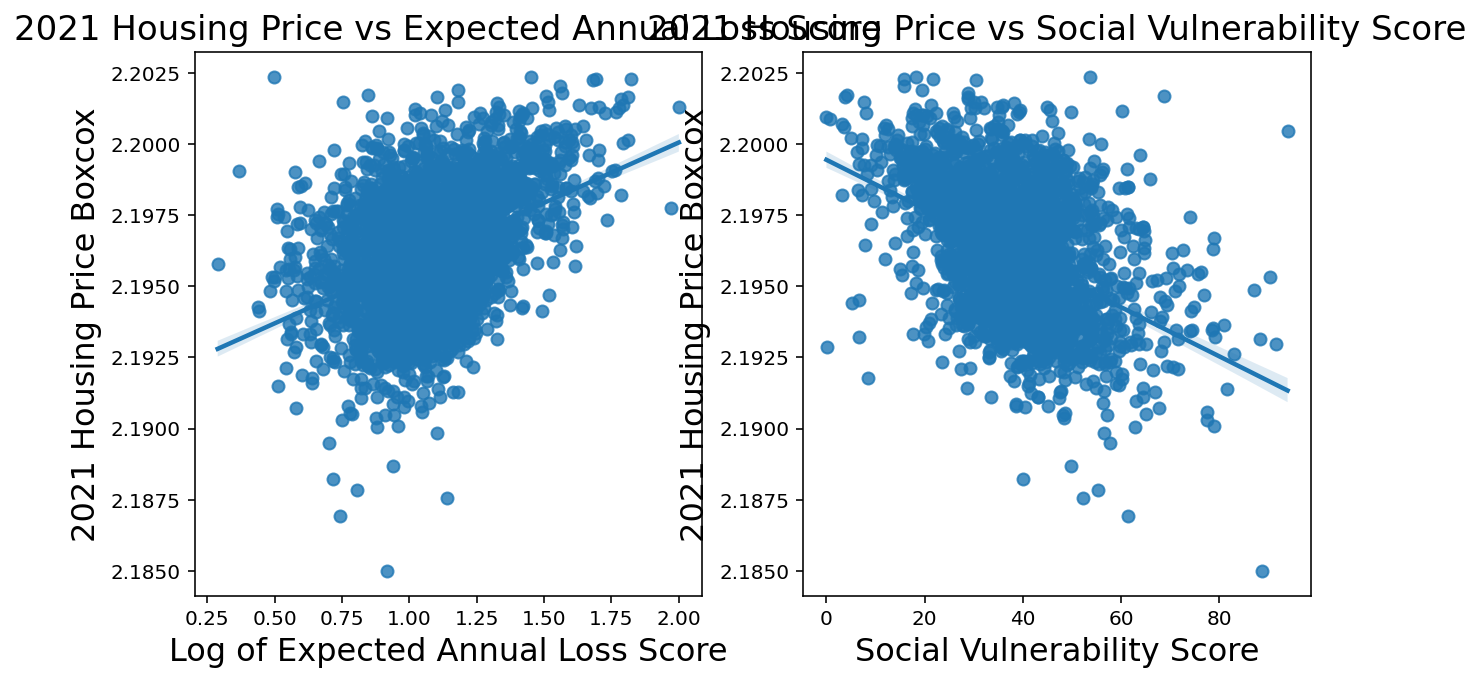

In [869]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.regplot(x= 'eal_score_log10', y= '2021_boxcox', data= df_housing_nri_merged, ax= ax1)
ax1.set_title('2021 Housing Price vs Expected Annual Loss Score', size= 17)
ax1.set_ylabel('2021 Housing Price Boxcox', fontsize = 16)
ax1.set_xlabel('Log of Expected Annual Loss Score', fontsize = 16)

sns.regplot(x= 'sovi_score', y= '2021_boxcox', data= df_housing_nri_merged, ax= ax2)
ax2.set_title('2021 Housing Price vs Social Vulnerability Score', size= 17)
ax2.set_ylabel('2021 Housing Price Boxcox', fontsize = 16)
ax2.set_xlabel('Social Vulnerability Score', fontsize = 16)

After verifying all assumptions, we fitted a multiple linear regression model. Looking at the coefficient for the expected annual loss score, we see that for every one unit increase in the expected annual loss score, the 2021 housing price increases by 0.0035 / 100 units, which is a very small effect size. Looking at the coefficient for social vulnerability score, we see that for every one unit increase in the social vulnerability score, the 2021 housing price decreases by -7.478e-05 units, which is also a very small effect size. We also observe that the adjusted R-squared value is 0.316, meaning that 31.6% of the variation in 2021 housing prices are explained by the expected annual loss score and social vulnerability score. This R-squared value is not very high, indicating that the model might not be very good at predicting 2021 housing prices. 

In [870]:
outcome_2, predictors_2 = patsy.dmatrices('Q("2021_boxcox") ~ eal_score_log10 + sovi_score', df_housing_nri_merged)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:       Q("2021_boxcox")   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     721.7
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          3.01e-258
Time:                        01:59:06   Log-Likelihood:                 15352.
No. Observations:                3117   AIC:                        -3.070e+04
Df Residuals:                    3114   BIC:                        -3.068e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1952      0.000   1.

# Ethics & Privacy

Initially, it’s hard to think of any biases our data can hold since most of it is a purely objective measurement. Our publicly available data will be collected by government agencies and nonprofits so they will come from a reputable source. We strive to be representative of all populations in our analysis but recognize that we may not fully represent all occupants, especially in terms of cost of living. We can remedy this by using the Cost of Living index which is based around the average person in that state. This way, we can accurately represent most of the state’s population. Furthermore, we understand that there may be a correlation between cost of living and number of natural disasters but we recognize that it may or may not be a definitive cause. If there is a correlation, we will also discuss possible external factors that may contribute more than natural disasters, such as climate, proximity to coast, and job opportunity within a state.

Nothing in our data will personally identify any single person but rather summarize something about the entire population of a state. It will be anonymous and unidentifiable. Also, since our datasets are collected by the government and nonprofits (which are updated regularly), there will be fluctuations in our results each year. This allows for an adaptable way to change and update our results. However, we recognize that the geographical location of each state and how they interact with natural disasters is historically fixed, which does not give much room for change in that regard. Therefore, since the data is publicly available and does not personally identify any single person, we do not believe that there will be any privacy or terms of use issues with the data. 

Lastly, when determining the safest state in terms of natural disasters, we are not implying that this state is safe overall. Of course, there will be many devastating natural disasters in the future and we should not lead people on with the idea that the 'safest state' is completely safe.


# Conclusion & Discussion

We can conclude that there is little to no corelation between housing prices and risk score. However, there is a weak to moderate correlation between the expected annual loss score and housing prices. We can infer this because our linear regression gave an adjusted r-squared value of nearly zero when comparing risk score and housing prices and our confidence interval included the null hypothesis (that there is no statistical relationship). As for EAL, we got an r-squared value of 0.171, which indicates a weak positive correlation and our confidence interval did not include the null hypothesis. When we combined the two as predictors for housing price, our adjusted r-squared because 0.316 which indicated a moderate positive correlation. For all three regressions, our p-value was 0.0 which means the probability that these results happened by chance was 0%.

# Team Contributions

- Tyler Le: Data Cleaning, EDA, Ethics & Privacy, Conclusion
- Aditya Tomar: Data Cleaning, EDA, Ethics & Privacy
- William Lynch: Data Cleaning, EDA
- Michael Mao: Background, Data Cleaning, EDA
- Natalie Quach: Background, Data Cleaning, EDA, Ethics & Privacy